# NESSIS Work

# Imports

In [454]:
# pip install tensorflow

In [455]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tables
import IPython.display
import os
import json
import tarfile
import random 
import tensorflow as tf
from tensorflow import keras
from keras.models import Model, Sequential, load_model
from keras import layers
from keras import losses
from keras import optimizers
from keras.callbacks import EarlyStopping, LambdaCallback, ModelCheckpoint
from keras.layers import Input, Embedding, SimpleRNN, GRU, LSTM, TimeDistributed, Bidirectional, Dense, RNN
from keras.layers import  BatchNormalization, Activation, Dropout, GaussianNoise
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras import backend as K
from sklearn.model_selection import train_test_split
from concurrent.futures import ProcessPoolExecutor, as_completed
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, GRU, Dense, Dropout, BatchNormalization, Attention, Concatenate
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Data Concatenation

**1.1 Inspecting Per Game Statistics**
To consider player realistic utilization

In [456]:
# Loading per game data for the past 10 years
data_15_16 = pd.read_excel('Data/Per_Game/15-16_Per_Game.xlsx')
data_16_17 = pd.read_excel('Data/Per_Game/16-17_Per_Game.xlsx')
data_17_18 = pd.read_excel('Data/Per_Game/17-18_Per_Game.xlsx')
data_18_19 = pd.read_excel('Data/Per_Game/18-19_Per_Game.xlsx')
data_19_20 = pd.read_excel('Data/Per_Game/19-20_Per_Game.xlsx')
data_20_21 = pd.read_excel('Data/Per_Game/20-21_Per_Game.xlsx')
data_21_22 = pd.read_excel('Data/Per_Game/21-22_Per_Game.xlsx')
data_22_23 = pd.read_excel('Data/Per_Game/22-23_Per_Game.xlsx')
data_23_24 = pd.read_excel('Data/Per_Game/23-24_Per_Game.xlsx')
data_24_25 = pd.read_excel('Data/Per_Game/24-25_Per_Game.xlsx')

# Checking for data consistency
print(data_15_16.columns)
print(data_24_25.columns)
data_24_25.tail(2)

Index(['Rk', 'Player', 'Age', 'Team', 'Pos', 'G', 'GS', 'MP', 'FG', 'FGA',
       'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA',
       'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
       'Awards', 'Player-additional'],
      dtype='object')
Index(['Rk', 'Player', 'Age', 'Team', 'Pos', 'G', 'GS', 'MP', 'FG', 'FGA',
       'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA',
       'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
       'Awards', 'Player-additional'],
      dtype='object')


,Rk,Player,Age,Team,Pos,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Awards,Player-additional
734,569.0,Terry Taylor,25.0,SAC,PF,3.0,0.0,2.0,0.0,0.3,0.000,0.0,0.0,NaN,0.0,0.3,0.000,0.000,0.0,0.0,NaN,0.3,0.0,0.3,0.7,0.0,0.0,0.0,0.0,0.0,NaN,taylote01
735,NaN,League Average,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.467,NaN,NaN,0.36,NaN,NaN,0.545,0.543,NaN,NaN,0.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9999


In [457]:
# List of all the dataframes
dataframes = [data_15_16, data_16_17, data_17_18, data_18_19, data_19_20,
              data_20_21, data_21_22, data_22_23, data_23_24, data_24_25]

per_game_renames = {
    'MP': 'MP_Per_Game','FG': 'FG_Per_Game','FGA': 'FGA_Per_Game','FG%': 'FG%_Per_Game', '3P': '3P_Per_Game','3PA': '3PA_Per_Game','3P%': '3P%_Per_Game','2P': '2P_Per_Game','2PA': '2PA_Per_Game','2P%': '2P%_Per_Game',
    'eFG%': 'eFG%_Per_Game','FT': 'FT_Per_Game','FTA': 'FTA_Per_Game','FT%': 'FT%_Per_Game','ORB': 'ORB_Per_Game','DRB': 'DRB_Per_Game','TRB': 'TRB_Per_Game','AST': 'AST_Per_Game','STL': 'STL_Per_Game','BLK': 'BLK_Per_Game','TOV': 'TOV_Per_Game','PF': 'PF_Per_Game','PTS': 'PTS_Per_Game',
}

for df in dataframes:
    df.rename(columns=per_game_renames, inplace=True)
    df.drop(df.tail(1).index, inplace=True)

print(data_15_16.columns)
data_15_16.tail(2)

for dataframe in dataframes:
    print(len(dataframe))

Index(['Rk', 'Player', 'Age', 'Team', 'Pos', 'G', 'GS', 'MP_Per_Game',
       'FG_Per_Game', 'FGA_Per_Game', 'FG%_Per_Game', '3P_Per_Game',
       '3PA_Per_Game', '3P%_Per_Game', '2P_Per_Game', '2PA_Per_Game',
       '2P%_Per_Game', 'eFG%_Per_Game', 'FT_Per_Game', 'FTA_Per_Game',
       'FT%_Per_Game', 'ORB_Per_Game', 'DRB_Per_Game', 'TRB_Per_Game',
       'AST_Per_Game', 'STL_Per_Game', 'BLK_Per_Game', 'TOV_Per_Game',
       'PF_Per_Game', 'PTS_Per_Game', 'Awards', 'Player-additional'],
      dtype='object')
578
595
664
708
651
705
812
679
735
735


**1.2 Per 36 Minute Data**
Considering Per 36 data to consider the potentials and perhaps lack of utilization of player

In [458]:

# Loading per 36 minute data for the past 10 years
per_36_data_15_16 = pd.read_excel('Data/Per_36/15-16_Per_36.xlsx')
per_36_data_16_17 = pd.read_excel('Data/Per_36/16-17_Per_36.xlsx')
per_36_data_17_18 = pd.read_excel('Data/Per_36/17-18_Per_36.xlsx')
per_36_data_18_19 = pd.read_excel('Data/Per_36/18-19_Per_36.xlsx')
per_36_data_19_20 = pd.read_excel('Data/Per_36/19-20_Per_36.xlsx')
per_36_data_20_21 = pd.read_excel('Data/Per_36/20-21_Per_36.xlsx')
per_36_data_21_22 = pd.read_excel('Data/Per_36/21-22_Per_36.xlsx')
per_36_data_22_23 = pd.read_excel('Data/Per_36/22-23_Per_36.xlsx')
per_36_data_23_24 = pd.read_excel('Data/Per_36/23-24_Per_36.xlsx')
per_36_data_24_25 = pd.read_excel('Data/Per_36/24-25_Per_36.xlsx')


# Checking for data consistency
print(per_36_data_15_16.columns)
print(per_36_data_24_25.columns)

Index(['Rk', 'Player', 'Age', 'Team', 'Pos', 'G', 'GS', 'MP', 'FG', 'FGA',
       'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA',
       'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
       'Awards', 'Player-additional'],
      dtype='object')
Index(['Rk', 'Player', 'Age', 'Team', 'Pos', 'G', 'GS', 'MP', 'FG', 'FGA',
       'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA',
       'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
       'Awards', 'Player-additional'],
      dtype='object')


In [459]:
# Large list of all the per 36 minute dataframes
per_36_dataframes = [per_36_data_15_16, per_36_data_16_17, per_36_data_17_18, per_36_data_18_19, per_36_data_19_20,
              per_36_data_20_21, per_36_data_21_22, per_36_data_22_23, per_36_data_23_24, per_36_data_24_25]

# Renaming columns for per 36 minute dataframes
per_36_renames = {  
    'FG': 'FG_Per_36','FGA': 'FGA_Per_36','FG%': 'FG%_Per_36', '3P': '3P_Per_36','3PA': '3PA_Per_36','3P%': '3P%_Per_36','2P': '2P_Per_36','2PA': '2PA_Per_36','2P%': '2P%_Per_36',
    'eFG%': 'eFG%_Per_36','FT': 'FT_Per_36','FTA': 'FTA_Per_36','FT%': 'FT%_Per_36','ORB': 'ORB_Per_36','DRB': 'DRB_Per_36','TRB': 'TRB_Per_36','AST': 'AST_Per_36','STL': 'STL_Per_36','BLK': 'BLK_Per_36','TOV': 'TOV_Per_36','PF': 'PF_Per_36','PTS': 'PTS_Per_36',
}

# Dropping unnecessary columns
for per_36_df in per_36_dataframes:
    per_36_df.rename(columns=per_36_renames, inplace=True)
    per_36_df.drop(per_36_df.tail(1).index, inplace=True)

In [460]:
print(per_36_data_24_25.columns)
per_36_data_15_16.tail(2)

Index(['Rk', 'Player', 'Age', 'Team', 'Pos', 'G', 'GS', 'MP', 'FG_Per_36',
       'FGA_Per_36', 'FG%_Per_36', '3P_Per_36', '3PA_Per_36', '3P%_Per_36',
       '2P_Per_36', '2PA_Per_36', '2P%_Per_36', 'eFG%_Per_36', 'FT_Per_36',
       'FTA_Per_36', 'FT%_Per_36', 'ORB_Per_36', 'DRB_Per_36', 'TRB_Per_36',
       'AST_Per_36', 'STL_Per_36', 'BLK_Per_36', 'TOV_Per_36', 'PF_Per_36',
       'PTS_Per_36', 'Awards', 'Player-additional'],
      dtype='object')


,Rk,Player,Age,Team,Pos,G,GS,MP,FG_Per_36,FGA_Per_36,FG%_Per_36,3P_Per_36,3PA_Per_36,3P%_Per_36,2P_Per_36,2PA_Per_36,2P%_Per_36,eFG%_Per_36,FT_Per_36,FTA_Per_36,FT%_Per_36,ORB_Per_36,DRB_Per_36,TRB_Per_36,AST_Per_36,STL_Per_36,BLK_Per_36,TOV_Per_36,PF_Per_36,PTS_Per_36,Awards,Player-additional
576,475.0,J.J. O'Brien,23.0,UTA,SF,2.0,0.0,6.0,0.0,6.0,0.0,0.0,0.0,NaN,0.0,6.0,0.0,0.0,0.0,0.0,NaN,0.0,6.0,6.0,0.0,6.0,0.0,0.0,6.0,0.0,NaN,obriejj01
577,476.0,Rakeem Christmas,24.0,IND,PF,1.0,0.0,6.0,12.0,12.0,1.0,0.0,0.0,NaN,12.0,12.0,1.0,1.0,0.0,0.0,NaN,6.0,0.0,6.0,0.0,0.0,0.0,0.0,6.0,24.0,NaN,chrisra01


**1.3 Advanced Statistics**
Finds underlying metrics of players

In [461]:
advanced_data_15_16 = pd.read_excel('Data/Advanced/15-16_Advanced.xlsx')
advanced_data_16_17 = pd.read_excel('Data/Advanced/16-17_Advanced.xlsx')
advanced_data_17_18 = pd.read_excel('Data/Advanced/17-18_Advanced.xlsx')
advanced_data_18_19 = pd.read_excel('Data/Advanced/18-19_Advanced.xlsx')
advanced_data_19_20 = pd.read_excel('Data/Advanced/19-20_Advanced.xlsx')
advanced_data_20_21 = pd.read_excel('Data/Advanced/20-21_Advanced.xlsx')
advanced_data_21_22 = pd.read_excel('Data/Advanced/21-22_Advanced.xlsx')
advanced_data_22_23 = pd.read_excel('Data/Advanced/22-23_Advanced.xlsx')
advanced_data_23_24 = pd.read_excel('Data/Advanced/23-24_Advanced.xlsx')
advanced_data_24_25 = pd.read_excel('Data/Advanced/24-25_Advanced.xlsx')

# Checking for data consistency
print(advanced_data_15_16.columns)
print(advanced_data_24_25.columns)

Index(['Rk', 'Player', 'Age', 'Team', 'Pos', 'G', 'GS', 'MP', 'PER', 'TS%',
       '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%',
       'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP',
       'Awards', 'Player-additional'],
      dtype='object')
Index(['Rk', 'Player', 'Age', 'Team', 'Pos', 'G', 'GS', 'MP', 'PER', 'TS%',
       '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%',
       'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP',
       'Awards', 'Player-additional'],
      dtype='object')


In [462]:
# Large list of all the advanced dataframes
advanced_dataframes = [advanced_data_15_16, advanced_data_16_17, advanced_data_17_18, advanced_data_18_19, advanced_data_19_20,
              advanced_data_20_21, advanced_data_21_22, advanced_data_22_23, advanced_data_23_24, advanced_data_24_25]

# Drop dataframes that are not needed
for advanced_df in advanced_dataframes:
    advanced_df.drop(columns=['Rk', 'Awards'], inplace=True)

**1.4 Shooting** Shooting Metrics

In [463]:
shooting_data_15_16 = pd.read_excel('Data/Shooting/15-16_Shooting.xlsx', dtype=str)
shooting_data_16_17 = pd.read_excel('Data/Shooting/16-17_Shooting.xlsx',dtype=str)
shooting_data_17_18 = pd.read_excel('Data/Shooting/17-18_Shooting.xlsx',dtype=str)
shooting_data_18_19 = pd.read_excel('Data/Shooting/18-19_Shooting.xlsx',dtype=str)
shooting_data_19_20 = pd.read_excel('Data/Shooting/19-20_Shooting.xlsx',dtype=str)
shooting_data_20_21 = pd.read_excel('Data/Shooting/20-21_Shooting.xlsx',dtype=str)
shooting_data_21_22 = pd.read_excel('Data/Shooting/21-22_Shooting.xlsx',dtype=str)
shooting_data_22_23 = pd.read_excel('Data/Shooting/22-23_Shooting.xlsx',dtype=str)
shooting_data_23_24 = pd.read_excel('Data/Shooting/23-24_Shooting.xlsx',dtype=str)
shooting_data_24_25 = pd.read_excel('Data/Shooting/24-25_Shooting.xlsx',dtype=str)

# Check the columns of the shooting dataframes
print(shooting_data_15_16.columns)
print(shooting_data_24_25.columns)

shooting_data_15_16.tail(5)

Index([                   'Rk',                'Player',
                         'Age',                  'Team',
                         'Pos',                     'G',
                          'GS',                    'MP',
                         'FG%',                 'Dist.',
                          '2P',                   '0-3',
           2025-03-10 00:00:00,     2025-10-16 00:00:00,
                       '16-3P',                    '3P',
                        '2P.1',                 '0-3.1',
       '2025-03-10 00:00:00.1', '2025-10-16 00:00:00.1',
                     '16-3P.1',                  '3P.1',
                        '2P.2',                  '3P.2',
                        '%FGA',                     '#',
                        '%3PA',                   '3P%',
                        'Att.',                   'Md.',
                      'Awards',                   -9999],
      dtype='object')
Index([                   'Rk',                'Player',
        

,Rk,Player,Age,Team,Pos,G,GS,MP,FG%,Dist.,2P,0-3,2025-03-10 00:00:00,2025-10-16 00:00:00,16-3P,3P,2P.1,0-3.1,2025-03-10 00:00:00.1,2025-10-16 00:00:00.1,16-3P.1,3P.1,2P.2,3P.2,%FGA,#,%3PA,3P%,Att.,Md.,Awards,-9999
574,473,Sam Dekker,21,HOU,PF,3,0,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0,NaN,dekkesa01
575,474,Thanasis Antetokounmpo,23,NYK,SF,2,0,6,0.75,7,0.75,0.75,0,0,0,0.25,1,1,NaN,NaN,NaN,0,0.333,NaN,0.5,2,0,NaN,0,0,NaN,antetth01
576,475,J.J. O'Brien,23,UTA,SF,2,0,6,0,9,1,0,1,0,0,0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0,0,NaN,obriejj01
577,476,Rakeem Christmas,24,IND,PF,1,0,6,1,0.5,1,1,0,0,0,0,1,1,NaN,NaN,NaN,NaN,1,NaN,0,0,NaN,NaN,0,0,NaN,chrisra01
578,NaN,League Average,NaN,NaN,NaN,NaN,NaN,NaN,0.452,12.2,0.715,0.293,0.158,0.103,0.162,0.285,0.491,0.624,0.396,0.405,0.398,0.354,0.51,0.836,0.048,NaN,0.248,0.377,NaN,NaN,NaN,-9999


In [464]:
# List of all the shooting dataframes
shooting_dataframes = [shooting_data_15_16, shooting_data_16_17, shooting_data_17_18, shooting_data_18_19, shooting_data_19_20,
              shooting_data_20_21, shooting_data_21_22, shooting_data_22_23, shooting_data_23_24, shooting_data_24_25]

# Renaming columns for shooting dataframes
shooting_renames = {
    'Dist.': 'Average_Shot_Distance', '2P%': '%_Shots_Attempts_From_2', '0-3': '%_Shots_Attempts_From_0-3', '2025-03-10 00:00:00': '%_Shots_Attempts_From_3-10',
    '2025-10-16 00:00:00': '%_Shots_Attempts_From_10-16', '16-3P': '%_Shots_Attempts_From_16-3P', '3P%': '%_Shots_Attempts_From_3', '2P.1': 'FG%_From_2',
    '0-3.1': 'FG%_From_0-3', '2025-03-10 00:00:00.1': 'FG%_From_3-10', '2025-10-16 00:00:00.1': 'FG%_From_10-16', '16-3P.1': 'FG%_From_16-3P', '3P.1': 'FG%_From_3',
    '2P.2': '%_FG_That_Were_Assisted_From_2', '3P.2': '%_FG_That_Were_Assisted_From_3', '%FGA': '%_FGA_That_Were_Dunks', '#': '#_Of_Made_Dunks', '%3PA': '%_3PA_That_Were_Corner_3s',
    '3P%': 'Corner_3P%', 'Att.': 'Heaves_Attempts', 'Md.': 'Heaves_Made'
}

# Renaming columns and dropping unnecessary columns
for shooting_df in shooting_dataframes:
    shooting_df.columns = shooting_df.columns.map(str)
    shooting_df.rename(columns=shooting_renames, inplace=True)
    shooting_df.drop(columns=['Rk', '-9999', 'Awards'], inplace=True)
    shooting_df.drop(shooting_df.tail(1).index, inplace=True)

print(shooting_data_15_16.columns)

Index(['Player', 'Age', 'Team', 'Pos', 'G', 'GS', 'MP', 'FG%',
       'Average_Shot_Distance', '2P', '%_Shots_Attempts_From_0-3',
       '%_Shots_Attempts_From_3-10', '%_Shots_Attempts_From_10-16',
       '%_Shots_Attempts_From_16-3P', '3P', 'FG%_From_2', 'FG%_From_0-3',
       'FG%_From_3-10', 'FG%_From_10-16', 'FG%_From_16-3P', 'FG%_From_3',
       '%_FG_That_Were_Assisted_From_2', '%_FG_That_Were_Assisted_From_3',
       '%_FGA_That_Were_Dunks', '#_Of_Made_Dunks', '%_3PA_That_Were_Corner_3s',
       'Corner_3P%', 'Heaves_Attempts', 'Heaves_Made'],
      dtype='object')


**1.5 Adjusted Shooting** More Shooting statistics

In [465]:
# Loading adjusted shooting data for the past 10 years
adjusted_shooting_data_15_16 = pd.read_excel('Data/Adjusted_Shooting/15-16_Adj_Shooting.xlsx')
adjusted_shooting_data_16_17 = pd.read_excel('Data/Adjusted_Shooting/16-17_Adj_Shooting.xlsx')
adjusted_shooting_data_17_18 = pd.read_excel('Data/Adjusted_Shooting/17-18_Adj_Shooting.xlsx')
adjusted_shooting_data_18_19 = pd.read_excel('Data/Adjusted_Shooting/18-19_Adj_Shooting.xlsx')
adjusted_shooting_data_19_20 = pd.read_excel('Data/Adjusted_Shooting/19-20_Adj_Shooting.xlsx')
adjusted_shooting_data_20_21 = pd.read_excel('Data/Adjusted_Shooting/20-21_Adj_Shooting.xlsx')
adjusted_shooting_data_21_22 = pd.read_excel('Data/Adjusted_Shooting/21-22_Adj_Shooting.xlsx')
adjusted_shooting_data_22_23 = pd.read_excel('Data/Adjusted_Shooting/22-23_Adj_Shooting.xlsx')
adjusted_shooting_data_23_24 = pd.read_excel('Data/Adjusted_Shooting/23-24_Adj_Shooting.xlsx')
adjusted_shooting_data_24_25 = pd.read_excel('Data/Adjusted_Shooting/24-25_Adj_Shooting.xlsx')

# Checking for data consistency
print(adjusted_shooting_data_15_16.columns)
print(adjusted_shooting_data_24_25.columns)

Index([    'Rk', 'Player',    'Age',   'Team',    'Pos',      'G',     'GS',
           'MP',    'FG%',    '2P%',    '3P%',   'eFG%',    'FT%',    'TS%',
          'FTr',   '3PAr',    'FG+',    '2P+',    '3P+',   'eFG+',    'FT+',
          'TS+',   'FTr+',  '3PAr+', 'FG Add', 'TS Add', 'Awards',    -9999],
      dtype='object')
Index([    'Rk', 'Player',    'Age',   'Team',    'Pos',      'G',     'GS',
           'MP',    'FG%',    '2P%',    '3P%',   'eFG%',    'FT%',    'TS%',
          'FTr',   '3PAr',    'FG+',    '2P+',    '3P+',   'eFG+',    'FT+',
          'TS+',   'FTr+',  '3PAr+', 'FG Add', 'TS Add', 'Awards',    -9999],
      dtype='object')


In [466]:
# large list of all the adjusted shooting dataframes
adjusted_shooting_dataframes = [adjusted_shooting_data_15_16, adjusted_shooting_data_16_17, adjusted_shooting_data_17_18, adjusted_shooting_data_18_19, adjusted_shooting_data_19_20,
              adjusted_shooting_data_20_21, adjusted_shooting_data_21_22, adjusted_shooting_data_22_23, adjusted_shooting_data_23_24, adjusted_shooting_data_24_25] 

# Dropping unnecessary columns
for adjusted_shooting_df in adjusted_shooting_dataframes:
    shooting_df.columns = shooting_df.columns.map(str)
    adjusted_shooting_df.drop(columns=['Rk', -9999, 'Awards'], inplace=True)
    adjusted_shooting_df.drop(adjusted_shooting_df.tail(1).index, inplace=True)

In [467]:
print(adjusted_shooting_data_15_16.columns)
adjusted_shooting_data_15_16.tail(5)

Index(['Player', 'Age', 'Team', 'Pos', 'G', 'GS', 'MP', 'FG%', '2P%', '3P%',
       'eFG%', 'FT%', 'TS%', 'FTr', '3PAr', 'FG+', '2P+', '3P+', 'eFG+', 'FT+',
       'TS+', 'FTr+', '3PAr+', 'FG Add', 'TS Add'],
      dtype='object')


,Player,Age,Team,Pos,G,GS,MP,FG%,2P%,3P%,eFG%,FT%,TS%,FTr,3PAr,FG+,2P+,3P+,eFG+,FT+,TS+,FTr+,3PAr+,FG Add,TS Add
573,Coty Clarke,23.0,BOS,SF,3.0,0.0,6.0,0.50,0.0,1.0,0.75,NaN,0.75,0.0,0.50,111.0,0.0,283.0,149.0,NaN,139.0,0.0,176.0,2.0,1.7
574,Sam Dekker,21.0,HOU,PF,3.0,0.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
575,Thanasis Antetokounmpo,23.0,NYK,SF,2.0,0.0,6.0,0.75,1.0,0.0,0.75,NaN,0.75,0.0,0.25,166.0,204.0,0.0,149.0,NaN,139.0,0.0,88.0,2.0,1.7
576,J.J. O'Brien,23.0,UTA,SF,2.0,0.0,6.0,0.00,0.0,NaN,0.00,NaN,0.00,0.0,0.00,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,-1.0,-1.1
577,Rakeem Christmas,24.0,IND,PF,1.0,0.0,6.0,1.00,1.0,NaN,1.00,NaN,1.00,0.0,0.00,221.0,204.0,NaN,199.0,NaN,185.0,0.0,0.0,2.0,1.8


**1.5.5 Totals**

In [468]:
# Load
totals_data_15_16 = pd.read_excel('Data/Total/15-16_Total.xlsx')
totals_data_16_17 = pd.read_excel('Data/Total/16-17_Total.xlsx')
totals_data_17_18 = pd.read_excel('Data/Total/17-18_Total.xlsx')
totals_data_18_19 = pd.read_excel('Data/Total/18-19_Total.xlsx')
totals_data_19_20 = pd.read_excel('Data/Total/19-20_Total.xlsx')
totals_data_20_21 = pd.read_excel('Data/Total/20-21_Total.xlsx')
totals_data_21_22 = pd.read_excel('Data/Total/21-22_Total.xlsx')
totals_data_22_23 = pd.read_excel('Data/Total/22-23_Total.xlsx')
totals_data_23_24 = pd.read_excel('Data/Total/23-24_Total.xlsx')
totals_data_24_25 = pd.read_excel('Data/Total/24-25_Total.xlsx')

# Checking for data consistency
print(totals_data_15_16.columns)
print(totals_data_24_25.columns)

totals_data_15_16.head(2)

Index(['Rk', 'Player', 'Age', 'Team', 'Pos', 'G', 'GS', 'MP', 'FG', 'FGA',
       'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA',
       'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
       'Trp-Dbl', 'Awards', 'Player-additional'],
      dtype='object')
Index(['Rk', 'Player', 'Age', 'Team', 'Pos', 'G', 'GS', 'MP', 'FG', 'FGA',
       'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA',
       'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
       'Trp-Dbl', 'Awards', 'Player-additional'],
      dtype='object')


,Rk,Player,Age,Team,Pos,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Trp-Dbl,Awards,Player-additional
0,1.0,James Harden,26.0,HOU,SG,82.0,82.0,3125.0,710.0,1617.0,0.439,236.0,657.0,0.359,474.0,960.0,0.494,0.512,720.0,837.0,0.860,63.0,438.0,501.0,612.0,139.0,51.0,374.0,229.0,2376.0,3.0,MVP-9AS,hardeja01
1,2.0,Stephen Curry,27.0,GSW,PG,79.0,79.0,2700.0,805.0,1598.0,0.504,402.0,886.0,0.454,403.0,712.0,0.566,0.630,363.0,400.0,0.908,68.0,362.0,430.0,527.0,169.0,15.0,262.0,161.0,2375.0,2.0,MVP-1ASNBA1,curryst01


In [469]:
# List of all the totals dataframes
totals_dataframes = [totals_data_15_16, totals_data_16_17, totals_data_17_18, totals_data_18_19, totals_data_19_20,
              totals_data_20_21, totals_data_21_22, totals_data_22_23, totals_data_23_24, totals_data_24_25]

# Renaming columns for totals dataframes
totals_renames = {
    'FG':'Total_FG','FGA': 'Total_FGA', '3P': 'Total_3P', '3PA': 'Total_3PA', '2P': 'Total_2P', '2PA': 'Total_2PA', 'FT': 'Total_FT', 'FTA': 'Total_FTA', 'ORB': 'Total_ORB', 'DRB': 'Total_DRB',
    'TRB': 'Total_TRB', 'AST': 'Total_AST', 'STL': 'Total_STL', 'BLK': 'Total_BLK', 'TOV': 'Total_TOV', 'PF': 'Total_PF', 'PTS': 'Total_PTS',
}

for i in range(len(totals_dataframes)):
    totals_dataframes[i].rename(columns=totals_renames, inplace=True)
    totals_dataframes[i].drop(columns=['Rk','Pos', 'G', 'GS', 'MP','FG%','3P%', '2P%','eFG%','FT%', 'Awards', 'Player-additional'], inplace=True)
    totals_dataframes[i].drop(totals_dataframes[i].tail(1).index, inplace=True)

In [470]:
print(list(totals_data_15_16.columns))
print(list(totals_data_24_25.dtypes))

['Player', 'Age', 'Team', 'Total_FG', 'Total_FGA', 'Total_3P', 'Total_3PA', 'Total_2P', 'Total_2PA', 'Total_FT', 'Total_FTA', 'Total_ORB', 'Total_DRB', 'Total_TRB', 'Total_AST', 'Total_STL', 'Total_BLK', 'Total_TOV', 'Total_PF', 'Total_PTS', 'Trp-Dbl']
[dtype('O'), dtype('float64'), dtype('O'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64')]


**1.6 Merges**

In [471]:
# Per 36 Minutes Merges

# List of all the dataframes
dataframes = [data_15_16, data_16_17, data_17_18, data_18_19, data_19_20,
              data_20_21, data_21_22, data_22_23, data_23_24, data_24_25]

per_36_dataframes = [per_36_data_15_16, per_36_data_16_17, per_36_data_17_18, per_36_data_18_19, per_36_data_19_20,
              per_36_data_20_21, per_36_data_21_22, per_36_data_22_23, per_36_data_23_24, per_36_data_24_25]

for i in range(len(dataframes)):
    # Clean column values
    for col in ['Player', 'Team']:
        dataframes[i][col] = dataframes[i][col].str.strip()
        per_36_dataframes[i][col] = per_36_dataframes[i][col].str.strip()

    # Merge on Player, Team, Age
    dataframes[i] = pd.merge(
        dataframes[i],
        per_36_dataframes[i],
        on=['Player', 'Team', 'Age'],
        how='inner'
    )

    # Drop suffix conflict columns if any exist
    dataframes[i] = dataframes[i].loc[:, ~dataframes[i].columns.str.endswith('_x')]
    dataframes[i] = dataframes[i].loc[:, ~dataframes[i].columns.str.endswith('_y')]

print(dataframes[0].columns)
print(len(dataframes[0]))

dataframes[0].tail(10)

Index(['Player', 'Age', 'Team', 'MP_Per_Game', 'FG_Per_Game', 'FGA_Per_Game',
       'FG%_Per_Game', '3P_Per_Game', '3PA_Per_Game', '3P%_Per_Game',
       '2P_Per_Game', '2PA_Per_Game', '2P%_Per_Game', 'eFG%_Per_Game',
       'FT_Per_Game', 'FTA_Per_Game', 'FT%_Per_Game', 'ORB_Per_Game',
       'DRB_Per_Game', 'TRB_Per_Game', 'AST_Per_Game', 'STL_Per_Game',
       'BLK_Per_Game', 'TOV_Per_Game', 'PF_Per_Game', 'PTS_Per_Game', 'MP',
       'FG_Per_36', 'FGA_Per_36', 'FG%_Per_36', '3P_Per_36', '3PA_Per_36',
       '3P%_Per_36', '2P_Per_36', '2PA_Per_36', '2P%_Per_36', 'eFG%_Per_36',
       'FT_Per_36', 'FTA_Per_36', 'FT%_Per_36', 'ORB_Per_36', 'DRB_Per_36',
       'TRB_Per_36', 'AST_Per_36', 'STL_Per_36', 'BLK_Per_36', 'TOV_Per_36',
       'PF_Per_36', 'PTS_Per_36'],
      dtype='object')
578


,Player,Age,Team,MP_Per_Game,FG_Per_Game,FGA_Per_Game,FG%_Per_Game,3P_Per_Game,3PA_Per_Game,3P%_Per_Game,2P_Per_Game,2PA_Per_Game,2P%_Per_Game,eFG%_Per_Game,FT_Per_Game,FTA_Per_Game,FT%_Per_Game,ORB_Per_Game,DRB_Per_Game,TRB_Per_Game,AST_Per_Game,STL_Per_Game,BLK_Per_Game,TOV_Per_Game,PF_Per_Game,PTS_Per_Game,MP,FG_Per_36,FGA_Per_36,FG%_Per_36,3P_Per_36,3PA_Per_36,3P%_Per_36,2P_Per_36,2PA_Per_36,2P%_Per_36,eFG%_Per_36,FT_Per_36,FTA_Per_36,FT%_Per_36,ORB_Per_36,DRB_Per_36,TRB_Per_36,AST_Per_36,STL_Per_36,BLK_Per_36,TOV_Per_36,PF_Per_36,PTS_Per_36
568,James Young,20.0,BOS,6.9,0.4,1.2,0.306,0.2,0.9,0.231,0.2,0.3,0.500,0.389,0.0,0.1,0.250,0.1,0.8,0.9,0.3,0.2,0.0,0.2,0.6,1.0,199.0,2.0,6.5,0.306,1.1,4.7,0.231,0.9,1.8,0.500,0.389,0.2,0.7,0.250,0.7,4.0,4.7,1.6,1.1,0.2,0.9,3.1,5.2
569,Joel Anthony,33.0,DET,5.1,0.3,0.5,0.600,0.0,0.0,NaN,0.3,0.5,0.600,0.600,0.3,0.4,0.750,0.4,0.7,1.1,0.1,0.1,0.6,0.1,0.8,0.9,96.0,2.3,3.7,0.600,0.0,0.0,NaN,2.3,3.7,0.600,0.600,2.3,3.0,0.750,3.0,4.9,7.9,0.4,0.7,4.5,0.7,5.6,6.8
570,Aaron Harrison,21.0,CHO,4.4,0.2,0.9,0.263,0.1,0.5,0.300,0.1,0.4,0.222,0.342,0.2,0.6,0.417,0.2,0.5,0.7,0.1,0.3,0.0,0.2,0.5,0.9,93.0,1.9,7.4,0.263,1.2,3.9,0.300,0.8,3.5,0.222,0.342,1.9,4.6,0.417,1.5,4.3,5.8,0.8,2.3,0.0,1.5,3.9,7.0
571,Sasha Kaun,30.0,CLE,3.8,0.4,0.7,0.529,0.0,0.0,NaN,0.4,0.7,0.529,0.529,0.2,0.4,0.455,0.5,0.6,1.0,0.1,0.2,0.2,0.3,0.4,0.9,95.0,3.4,6.4,0.529,0.0,0.0,NaN,3.4,6.4,0.529,0.529,1.9,4.2,0.455,4.5,5.3,9.9,1.1,1.5,1.9,2.7,4.2,8.7
572,Branden Dawson,22.0,LAC,4.8,0.3,0.8,0.400,0.0,0.0,NaN,0.3,0.8,0.400,0.400,0.2,0.2,1.000,0.3,0.3,0.7,0.0,0.0,0.2,0.0,0.3,0.8,29.0,2.5,6.2,0.400,0.0,0.0,NaN,2.5,6.2,0.400,0.400,1.2,1.2,1.000,2.5,2.5,5.0,0.0,0.0,1.2,0.0,2.5,6.2
573,Joe Harris,24.0,CLE,3.0,0.2,0.8,0.250,0.2,0.8,0.250,0.0,0.0,NaN,0.375,0.0,0.0,NaN,0.0,0.6,0.6,0.4,0.0,0.0,0.2,0.2,0.6,15.0,2.4,9.6,0.250,2.4,9.6,0.250,0.0,0.0,NaN,0.375,0.0,0.0,NaN,0.0,7.2,7.2,4.8,0.0,0.0,2.4,2.4,7.2
574,Bruno Caboclo,20.0,TOR,7.2,0.2,2.0,0.083,0.2,1.2,0.143,0.0,0.8,0.000,0.125,0.0,0.0,NaN,0.2,0.2,0.3,0.2,0.3,0.2,0.7,0.3,0.5,43.0,0.8,10.0,0.083,0.8,5.9,0.143,0.0,4.2,0.000,0.125,0.0,0.0,NaN,0.8,0.8,1.7,0.8,1.7,0.8,3.3,1.7,2.5
575,Sam Dekker,21.0,HOU,2.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.3,0.3,0.0,0.3,0.0,0.0,0.0,0.0,6.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,6.0,6.0,0.0,6.0,0.0,0.0,0.0,0.0
576,J.J. O'Brien,23.0,UTA,3.0,0.0,0.5,0.000,0.0,0.0,NaN,0.0,0.5,0.000,0.000,0.0,0.0,NaN,0.0,0.5,0.5,0.0,0.5,0.0,0.0,0.5,0.0,6.0,0.0,6.0,0.000,0.0,0.0,NaN,0.0,6.0,0.000,0.000,0.0,0.0,NaN,0.0,6.0,6.0,0.0,6.0,0.0,0.0,6.0,0.0
577,Nate Robinson,31.0,NOP,11.5,0.0,0.5,0.000,0.0,0.5,0.000,0.0,0.0,NaN,0.000,0.0,0.0,NaN,0.0,0.0,0.0,2.0,0.5,0.0,0.0,2.5,0.0,23.0,0.0,1.6,0.000,0.0,1.6,0.000,0.0,0.0,NaN,0.000,0.0,0.0,NaN,0.0,0.0,0.0,6.3,1.6,0.0,0.0,7.8,0.0


In [472]:
# Advanced dataframes
advanced_dataframes = [advanced_data_15_16, advanced_data_16_17,
              advanced_data_17_18, advanced_data_18_19, advanced_data_19_20,
              advanced_data_20_21, advanced_data_21_22, advanced_data_22_23,
              advanced_data_23_24, advanced_data_24_25]

for i in range(len(dataframes)):
    df = dataframes[i]
    adv = advanced_dataframes[i]

    # Strip and standardize column names
    df.columns = df.columns.map(str).str.strip()
    adv.columns = adv.columns.map(str).str.strip()

    # Convert 'Age' columns to numeric, handling errors
    df['Age'] = pd.to_numeric(df['Age'], errors='coerce').astype('float64')
    adv['Age'] = pd.to_numeric(adv['Age'], errors='coerce').astype('float64')

    # Strip merge key values (whitespace cleanup)
    for col in ['Player', 'Team']:
        df[col] = df[col].str.strip()
        adv[col] = adv[col].str.strip()

    # Drop overlapping columns except merge keys
    merge_keys = {'Player', 'Team', 'Age'}
    overlap = set(df.columns) & set(adv.columns) - merge_keys
    adv_clean = adv.drop(columns=overlap)

    # Merge using all three keys
    dataframes[i] = pd.merge(df, adv_clean, on=['Player', 'Team', 'Age'], how='inner')

dataframes[0].tail(10)


,Player,Age,Team,MP_Per_Game,FG_Per_Game,FGA_Per_Game,FG%_Per_Game,3P_Per_Game,3PA_Per_Game,3P%_Per_Game,2P_Per_Game,2PA_Per_Game,2P%_Per_Game,eFG%_Per_Game,FT_Per_Game,FTA_Per_Game,FT%_Per_Game,ORB_Per_Game,DRB_Per_Game,TRB_Per_Game,AST_Per_Game,STL_Per_Game,BLK_Per_Game,TOV_Per_Game,PF_Per_Game,PTS_Per_Game,MP,FG_Per_36,FGA_Per_36,FG%_Per_36,3P_Per_36,3PA_Per_36,3P%_Per_36,2P_Per_36,2PA_Per_36,2P%_Per_36,eFG%_Per_36,FT_Per_36,FTA_Per_36,FT%_Per_36,ORB_Per_36,DRB_Per_36,TRB_Per_36,AST_Per_36,STL_Per_36,BLK_Per_36,TOV_Per_36,PF_Per_36,PTS_Per_36,Pos,G,GS,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Player-additional
568,James Young,20.0,BOS,6.9,0.4,1.2,0.306,0.2,0.9,0.231,0.2,0.3,0.500,0.389,0.0,0.1,0.250,0.1,0.8,0.9,0.3,0.2,0.0,0.2,0.6,1.0,199.0,2.0,6.5,0.306,1.1,4.7,0.231,0.9,1.8,0.500,0.389,0.2,0.7,0.250,0.7,4.0,4.7,1.6,1.1,0.2,0.9,3.1,5.2,SG,29.0,0.0,3.6,0.384,0.722,0.111,2.1,11.9,6.9,6.0,1.5,0.4,11.7,9.1,-0.2,0.2,0.1,0.013,-5.3,0.8,-4.5,-0.1,youngja01
569,Joel Anthony,33.0,DET,5.1,0.3,0.5,0.600,0.0,0.0,NaN,0.3,0.5,0.600,0.600,0.3,0.4,0.750,0.4,0.7,1.1,0.1,0.1,0.6,0.1,0.8,0.9,96.0,2.3,3.7,0.600,0.0,0.0,NaN,2.3,3.7,0.600,0.600,2.3,3.0,0.750,3.0,4.9,7.9,0.4,0.7,4.5,0.7,5.6,6.8,C,19.0,0.0,14.1,0.666,0.000,0.800,8.8,15.4,11.9,1.4,1.1,9.5,12.9,7.0,0.2,0.2,0.4,0.177,-2.9,3.3,0.4,0.1,anthojo01
570,Aaron Harrison,21.0,CHO,4.4,0.2,0.9,0.263,0.1,0.5,0.300,0.1,0.4,0.222,0.342,0.2,0.6,0.417,0.2,0.5,0.7,0.1,0.3,0.0,0.2,0.5,0.9,93.0,1.9,7.4,0.263,1.2,3.9,0.300,0.8,3.5,0.222,0.342,1.9,4.6,0.417,1.5,4.3,5.8,0.8,2.3,0.0,1.5,3.9,7.0,SG,21.0,0.0,4.3,0.371,0.526,0.632,4.7,13.1,8.8,3.0,3.2,0.0,14.1,13.7,-0.2,0.1,0.0,-0.014,-7.2,0.9,-6.3,-0.1,harriaa01
571,Sasha Kaun,30.0,CLE,3.8,0.4,0.7,0.529,0.0,0.0,NaN,0.4,0.7,0.529,0.529,0.2,0.4,0.455,0.5,0.6,1.0,0.1,0.2,0.2,0.3,0.4,0.9,95.0,3.4,6.4,0.529,0.0,0.0,NaN,3.4,6.4,0.529,0.529,1.9,4.2,0.455,4.5,5.3,9.9,1.1,1.5,1.9,2.7,4.2,8.7,C,25.0,0.0,12.5,0.527,0.000,0.647,14.4,16.5,15.5,4.5,2.2,4.3,24.3,13.7,0.0,0.2,0.2,0.096,-3.3,0.5,-2.8,0.0,kaunsa01
572,Branden Dawson,22.0,LAC,4.8,0.3,0.8,0.400,0.0,0.0,NaN,0.3,0.8,0.400,0.400,0.2,0.2,1.000,0.3,0.3,0.7,0.0,0.0,0.2,0.0,0.3,0.8,29.0,2.5,6.2,0.400,0.0,0.0,NaN,2.5,6.2,0.400,0.400,1.2,1.2,1.000,2.5,2.5,5.0,0.0,0.0,1.2,0.0,2.5,6.2,PF,6.0,0.0,7.1,0.460,0.000,0.200,7.6,7.4,7.5,0.0,0.0,2.7,0.0,8.5,0.0,0.0,0.0,0.069,-3.6,-2.0,-5.7,0.0,dawsobr01
573,Joe Harris,24.0,CLE,3.0,0.2,0.8,0.250,0.2,0.8,0.250,0.0,0.0,NaN,0.375,0.0,0.0,NaN,0.0,0.6,0.6,0.4,0.0,0.0,0.2,0.2,0.6,15.0,2.4,9.6,0.250,2.4,9.6,0.250,0.0,0.0,NaN,0.375,0.0,0.0,NaN,0.0,7.2,7.2,4.8,0.0,0.0,2.4,2.4,7.2,SG,5.0,0.0,3.4,0.375,1.000,0.000,0.0,22.5,11.3,18.2,0.0,0.0,20.0,15.1,0.0,0.0,0.0,-0.032,-5.0,-0.9,-5.9,0.0,harrijo01
574,Bruno Caboclo,20.0,TOR,7.2,0.2,2.0,0.083,0.2,1.2,0.143,0.0,0.8,0.000,0.125,0.0,0.0,NaN,0.2,0.2,0.3,0.2,0.3,0.2,0.7,0.3,0.5,43.0,0.8,10.0,0.083,0.8,5.9,0.143,0.0,4.2,0.000,0.125,0.0,0.0,NaN,0.8,0.8,1.7,0.8,1.7,0.8,3.3,1.7,2.5,SF,6.0,1.0,-7.7,0.125,0.583,0.000,2.7,2.6,2.7,3.2,2.4,1.9,25.0,16.9,-0.3,0.0,-0.3,-0.283,-14.0,-3.6,-17.6,-0.2,cabocbr01
575,Sam Dekker,21.0,HOU,2.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.3,0.3,0.0,0.3,0.0,0.0,0.0,0.0,6.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,6.0,6.0,0.0,6.0,0.0,0.0,0.0,0.0,PF,3.0,0.0,10.8,NaN,NaN,NaN,0.0,18.5,9.2,0.0,8.2,0.0,NaN,0.0,0.0,0.0,0.0,0.116,-2.8,5.1,2.2,0.0,dekkesa01
576,J.J. O'Brien,23.0,UTA,3.0,0.0,0.5,0.000,0.0,0.0,NaN,0.0,0.5,0.000,0.000,0.0,0.0,NaN,0.0,0.5,0.5,0.0,0.5,0.0,0.0,0.5,0.0,6.0,0.0,6.0,0.000,0.0,0.0,NaN,0.0,6.0,0.000,0.000,0.0,0.0,NaN,0.0,6.0,6.0,0.0,6.0,0.0,0.0,6.0,0.0,SF,2.0,0.0,1.3,0.000,0.000,0.000,0.0,19.4,9.7,0.0,8.8,0.0,0.0,7.7,0.0,0.0,0.0,-0.028,-11.5,5.3,-6.2,0.0,obriejj01
577,Nate Robinson,31.0,NOP,11.5,0.0,0.5,0.000,0.0,0.5,0.000,0.0,0.0,NaN,0.000,0.0,0.0,NaN,0.0,0.0,0.0,2.0,0.5,0.0,0.0,2.5,0.0,23.0,0.0,1.6,0.000,0.0,1.6,0.000,0.0,0.0,NaN,0.000,0.0,0.0,NaN,0.0,0.0,0.0,6.3,1.6,0.0,0.0,7.8,0.0,PG,2.0,1.0,2.6,0.000,1.000,0.000,0.0,0.0,0.

In [473]:
# Shooting dataframes
shooting_dataframes = [shooting_data_15_16, shooting_data_16_17, shooting_data_17_18, shooting_data_18_19, shooting_data_19_20,
              shooting_data_20_21, shooting_data_21_22, shooting_data_22_23, shooting_data_23_24, shooting_data_24_25]

for i in range(len(dataframes)):
    df = dataframes[i]
    shoot = shooting_dataframes[i]

    # Clean column names
    df.columns = df.columns.map(str).str.strip()
    shoot.columns = shoot.columns.map(str).str.strip()

    # Strip whitespace from Player and Team
    for col in ['Player', 'Team']:
        df[col] = df[col].str.strip()
        shoot[col] = shoot[col].str.strip()

    # Ensure Age is numeric and consistent
    df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
    shoot['Age'] = pd.to_numeric(shoot['Age'], errors='coerce')

    # Drop overlapping columns (except for keys)
    merge_keys = {'Player', 'Team', 'Age'}
    overlap = set(df.columns) & set(shoot.columns) - merge_keys
    shoot_clean = shoot.drop(columns=overlap)

    # Merge into the main dataframe
    dataframes[i] = pd.merge(df, shoot_clean, on=['Player', 'Team', 'Age'], how='inner')

dataframes[0].tail(5)

,Player,Age,Team,MP_Per_Game,FG_Per_Game,FGA_Per_Game,FG%_Per_Game,3P_Per_Game,3PA_Per_Game,3P%_Per_Game,2P_Per_Game,2PA_Per_Game,2P%_Per_Game,eFG%_Per_Game,FT_Per_Game,FTA_Per_Game,FT%_Per_Game,ORB_Per_Game,DRB_Per_Game,TRB_Per_Game,AST_Per_Game,STL_Per_Game,BLK_Per_Game,TOV_Per_Game,PF_Per_Game,PTS_Per_Game,MP,FG_Per_36,FGA_Per_36,FG%_Per_36,3P_Per_36,3PA_Per_36,3P%_Per_36,2P_Per_36,2PA_Per_36,2P%_Per_36,eFG%_Per_36,FT_Per_36,FTA_Per_36,FT%_Per_36,ORB_Per_36,DRB_Per_36,TRB_Per_36,AST_Per_36,STL_Per_36,BLK_Per_36,TOV_Per_36,PF_Per_36,PTS_Per_36,Pos,G,GS,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Player-additional,FG%,Average_Shot_Distance,2P,%_Shots_Attempts_From_0-3,%_Shots_Attempts_From_3-10,%_Shots_Attempts_From_10-16,%_Shots_Attempts_From_16-3P,3P,FG%_From_2,FG%_From_0-3,FG%_From_3-10,FG%_From_10-16,FG%_From_16-3P,FG%_From_3,%_FG_That_Were_Assisted_From_2,%_FG_That_Were_Assisted_From_3,%_FGA_That_Were_Dunks,#_Of_Made_Dunks,%_3PA_That_Were_Corner_3s,Corner_3P%,Heaves_Attempts,Heaves_Made
573,Joe Harris,24.0,CLE,3.0,0.2,0.8,0.250,0.2,0.8,0.250,0.0,0.0,NaN,0.375,0.0,0.0,NaN,0.0,0.6,0.6,0.4,0.0,0.0,0.2,0.2,0.6,15.0,2.4,9.6,0.250,2.4,9.6,0.250,0.0,0.0,NaN,0.375,0.0,0.0,NaN,0.0,7.2,7.2,4.8,0.0,0.0,2.4,2.4,7.2,SG,5.0,0.0,3.4,0.375,1.000,0.0,0.0,22.5,11.3,18.2,0.0,0.0,20.0,15.1,0.0,0.0,0.0,-0.032,-5.0,-0.9,-5.9,0.0,harrijo01,0.25,25,0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,0.25,NaN,1,0,0,0.25,1,0,0
574,Bruno Caboclo,20.0,TOR,7.2,0.2,2.0,0.083,0.2,1.2,0.143,0.0,0.8,0.0,0.125,0.0,0.0,NaN,0.2,0.2,0.3,0.2,0.3,0.2,0.7,0.3,0.5,43.0,0.8,10.0,0.083,0.8,5.9,0.143,0.0,4.2,0.0,0.125,0.0,0.0,NaN,0.8,0.8,1.7,0.8,1.7,0.8,3.3,1.7,2.5,SF,6.0,1.0,-7.7,0.125,0.583,0.0,2.7,2.6,2.7,3.2,2.4,1.9,25.0,16.9,-0.3,0.0,-0.3,-0.283,-14.0,-3.6,-17.6,-0.2,cabocbr01,0.083,18.9,0.417,0,0.167,0.083,0.167,0.583,0,NaN,0,0,0,0.143,NaN,1,0,0,0.714,0.2,0,0
575,Sam Dekker,21.0,HOU,2.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.3,0.3,0.0,0.3,0.0,0.0,0.0,0.0,6.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,6.0,6.0,0.0,6.0,0.0,0.0,0.0,0.0,PF,3.0,0.0,10.8,NaN,NaN,NaN,0.0,18.5,9.2,0.0,8.2,0.0,NaN,0.0,0.0,0.0,0.0,0.116,-2.8,5.1,2.2,0.0,dekkesa01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0
576,J.J. O'Brien,23.0,UTA,3.0,0.0,0.5,0.000,0.0,0.0,NaN,0.0,0.5,0.0,0.000,0.0,0.0,NaN,0.0,0.5,0.5,0.0,0.5,0.0,0.0,0.5,0.0,6.0,0.0,6.0,0.000,0.0,0.0,NaN,0.0,6.0,0.0,0.000,0.0,0.0,NaN,0.0,6.0,6.0,0.0,6.0,0.0,0.0,6.0,0.0,SF,2.0,0.0,1.3,0.000,0.000,0.0,0.0,19.4,9.7,0.0,8.8,0.0,0.0,7.7,0.0,0.0,0.0,-0.028,-11.5,5.3,-6.2,0.0,obriejj01,0,9,1,0,1,0,0,0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0,0
577,Nate Robinson,31.0,NOP,11.5,0.0,0.5,0.000,0.0,0.5,0.000,0.0,0.0,NaN,0.000,0.0,0.0,NaN,0.0,0.0,0.0,2.0,0.5,0.0,0.0,2.5,0.0,23.0,0.0,1.6,0.000,0.0,1.6,0.000,0.0,0.0,NaN,0.000,0.0,0.0,NaN,0.0,0.0,0.0,6.3,1.6,0.0,0.0,7.8,0.0,PG,2.0,1.0,2.6,0.000,1.000,0.0,0.0,0.0,0.0,21.8,2.2,0.0,0.0,1.9,0.0,0.0,0.0,0.038,-6.6,2.0,-4.6,0.0,robinna01,0,24,0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0,0,NaN,0,0


In [474]:
# Merging Adjusted Shooting Dataframes
adjusted_shooting_dataframes = [adjusted_shooting_data_15_16, adjusted_shooting_data_16_17, adjusted_shooting_data_17_18, adjusted_shooting_data_18_19, adjusted_shooting_data_19_20,
              adjusted_shooting_data_20_21, adjusted_shooting_data_21_22, adjusted_shooting_data_22_23, adjusted_shooting_data_23_24, adjusted_shooting_data_24_25] 

for i in range(len(dataframes)):
    df = dataframes[i]
    adj_shoot = adjusted_shooting_dataframes[i]

    # Clean column names
    df.columns = df.columns.map(str).str.strip()
    adj_shoot.columns = adj_shoot.columns.map(str).str.strip()

    # Strip whitespace from Player and Team
    for col in ['Player', 'Team']:
        df[col] = df[col].str.strip()
        adj_shoot[col] = adj_shoot[col].str.strip()

    # Ensure Age is numeric and consistent
    df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
    adj_shoot['Age'] = pd.to_numeric(adj_shoot['Age'], errors='coerce')

    # Drop overlapping columns (except for keys)
    merge_keys = {'Player', 'Team', 'Age'}
    overlap = set(df.columns) & set(adj_shoot.columns) - merge_keys
    adj_shoot_clean = adj_shoot.drop(columns=overlap)

    # Merge into the main dataframe
    dataframes[i] = pd.merge(df, adj_shoot_clean, on=['Player', 'Team', 'Age'], how='inner')

dataframes[0].tail(5)

,Player,Age,Team,MP_Per_Game,FG_Per_Game,FGA_Per_Game,FG%_Per_Game,3P_Per_Game,3PA_Per_Game,3P%_Per_Game,2P_Per_Game,2PA_Per_Game,2P%_Per_Game,eFG%_Per_Game,FT_Per_Game,FTA_Per_Game,FT%_Per_Game,ORB_Per_Game,DRB_Per_Game,TRB_Per_Game,AST_Per_Game,STL_Per_Game,BLK_Per_Game,TOV_Per_Game,PF_Per_Game,PTS_Per_Game,MP,FG_Per_36,FGA_Per_36,FG%_Per_36,3P_Per_36,3PA_Per_36,3P%_Per_36,2P_Per_36,2PA_Per_36,2P%_Per_36,eFG%_Per_36,FT_Per_36,FTA_Per_36,FT%_Per_36,ORB_Per_36,DRB_Per_36,TRB_Per_36,AST_Per_36,STL_Per_36,BLK_Per_36,TOV_Per_36,PF_Per_36,PTS_Per_36,Pos,G,GS,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Player-additional,FG%,Average_Shot_Distance,2P,%_Shots_Attempts_From_0-3,%_Shots_Attempts_From_3-10,%_Shots_Attempts_From_10-16,%_Shots_Attempts_From_16-3P,3P,FG%_From_2,FG%_From_0-3,FG%_From_3-10,FG%_From_10-16,FG%_From_16-3P,FG%_From_3,%_FG_That_Were_Assisted_From_2,%_FG_That_Were_Assisted_From_3,%_FGA_That_Were_Dunks,#_Of_Made_Dunks,%_3PA_That_Were_Corner_3s,Corner_3P%,Heaves_Attempts,Heaves_Made,2P%,3P%,eFG%,FT%,FG+,2P+,3P+,eFG+,FT+,TS+,FTr+,3PAr+,FG Add,TS Add
573,Joe Harris,24.0,CLE,3.0,0.2,0.8,0.250,0.2,0.8,0.250,0.0,0.0,NaN,0.375,0.0,0.0,NaN,0.0,0.6,0.6,0.4,0.0,0.0,0.2,0.2,0.6,15.0,2.4,9.6,0.250,2.4,9.6,0.250,0.0,0.0,NaN,0.375,0.0,0.0,NaN,0.0,7.2,7.2,4.8,0.0,0.0,2.4,2.4,7.2,SG,5.0,0.0,3.4,0.375,1.000,0.0,0.0,22.5,11.3,18.2,0.0,0.0,20.0,15.1,0.0,0.0,0.0,-0.032,-5.0,-0.9,-5.9,0.0,harrijo01,0.25,25,0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,0.25,NaN,1,0,0,0.25,1,0,0,NaN,0.250,0.375,NaN,55.0,NaN,71.0,75.0,NaN,69.0,0.0,351.0,-1.0,-1.3
574,Bruno Caboclo,20.0,TOR,7.2,0.2,2.0,0.083,0.2,1.2,0.143,0.0,0.8,0.0,0.125,0.0,0.0,NaN,0.2,0.2,0.3,0.2,0.3,0.2,0.7,0.3,0.5,43.0,0.8,10.0,0.083,0.8,5.9,0.143,0.0,4.2,0.0,0.125,0.0,0.0,NaN,0.8,0.8,1.7,0.8,1.7,0.8,3.3,1.7,2.5,SF,6.0,1.0,-7.7,0.125,0.583,0.0,2.7,2.6,2.7,3.2,2.4,1.9,25.0,16.9,-0.3,0.0,-0.3,-0.283,-14.0,-3.6,-17.6,-0.2,cabocbr01,0.083,18.9,0.417,0,0.167,0.083,0.167,0.583,0,NaN,0,0,0,0.143,NaN,1,0,0,0.714,0.2,0,0,0.0,0.143,0.125,NaN,18.0,0.0,40.0,25.0,NaN,23.0,0.0,205.0,-9.1,-10.0
575,Sam Dekker,21.0,HOU,2.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.3,0.3,0.0,0.3,0.0,0.0,0.0,0.0,6.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,6.0,6.0,0.0,6.0,0.0,0.0,0.0,0.0,PF,3.0,0.0,10.8,NaN,NaN,NaN,0.0,18.5,9.2,0.0,8.2,0.0,NaN,0.0,0.0,0.0,0.0,0.116,-2.8,5.1,2.2,0.0,dekkesa01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
576,J.J. O'Brien,23.0,UTA,3.0,0.0,0.5,0.000,0.0,0.0,NaN,0.0,0.5,0.0,0.000,0.0,0.0,NaN,0.0,0.5,0.5,0.0,0.5,0.0,0.0,0.5,0.0,6.0,0.0,6.0,0.000,0.0,0.0,NaN,0.0,6.0,0.0,0.000,0.0,0.0,NaN,0.0,6.0,6.0,0.0,6.0,0.0,0.0,6.0,0.0,SF,2.0,0.0,1.3,0.000,0.000,0.0,0.0,19.4,9.7,0.0,8.8,0.0,0.0,7.7,0.0,0.0,0.0,-0.028,-11.5,5.3,-6.2,0.0,obriejj01,0,9,1,0,1,0,0,0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0,0,0.0,NaN,0.000,NaN,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,-1.0,-1.1
577,Nate Robinson,31.0,NOP,11.5,0.0,0.5,0.000,0.0,0.5,0.000,0.0,0.0,NaN,0.000,0.0,0.0,NaN,0.0,0.0,0.0,2.0,0.5,0.0,0.0,2.5,0.0,23.0,0.0,1.6,0.000,0.0,1.6,0.000,0.0,0.0,NaN,0.000,0.0,0.0,NaN,0.0,0.0,0.0,6.3,1.6,0.0,0.0,7.8,0.0,PG,2.0,1.0,2.6,0.000,1.000,0.0,0.0,0.0,0.0,21.8,2.2,0.0,0.0,1.9,0.0,0.0,0.0,0.038,-6.6,2.0,-4.6,0.0,robinna01,0,24,0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0,0,NaN,0,0,NaN,0.000,0.000,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,351.0,-1.0,-1.1


In [475]:
# Merge Totals Dataframes
totals_dataframes = [totals_data_15_16, totals_data_16_17, totals_data_17_18, totals_data_18_19, totals_data_19_20,
              totals_data_20_21, totals_data_21_22, totals_data_22_23, totals_data_23_24, totals_data_24_25]

for i in range(len(dataframes)):
    df = dataframes[i]
    totals = totals_dataframes[i]

    # Clean column names
    df.columns = df.columns.map(str).str.strip()
    totals.columns = totals.columns.map(str).str.strip()

    # Strip whitespace from Player and Team
    for col in ['Player', 'Team']:
        df[col] = df[col].str.strip()
        totals[col] = totals[col].str.strip()

    # Ensure Age is numeric and consistent
    df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
    totals['Age'] = pd.to_numeric(totals['Age'], errors='coerce')

    # Drop overlapping columns (except for keys)
    merge_keys = {'Player', 'Team', 'Age'}
    overlap = set(df.columns) & set(totals.columns) - merge_keys
    totals_clean = totals.drop(columns=overlap)

    # Merge into the main dataframe
    dataframes[i] = pd.merge(df, totals_clean, on=['Player', 'Team', 'Age'], how='inner')


dataframes[0].tail(5)

,Player,Age,Team,MP_Per_Game,FG_Per_Game,FGA_Per_Game,FG%_Per_Game,3P_Per_Game,3PA_Per_Game,3P%_Per_Game,2P_Per_Game,2PA_Per_Game,2P%_Per_Game,eFG%_Per_Game,FT_Per_Game,FTA_Per_Game,FT%_Per_Game,ORB_Per_Game,DRB_Per_Game,TRB_Per_Game,AST_Per_Game,STL_Per_Game,BLK_Per_Game,TOV_Per_Game,PF_Per_Game,PTS_Per_Game,MP,FG_Per_36,FGA_Per_36,FG%_Per_36,3P_Per_36,3PA_Per_36,3P%_Per_36,2P_Per_36,2PA_Per_36,2P%_Per_36,eFG%_Per_36,FT_Per_36,FTA_Per_36,FT%_Per_36,ORB_Per_36,DRB_Per_36,TRB_Per_36,AST_Per_36,STL_Per_36,BLK_Per_36,TOV_Per_36,PF_Per_36,PTS_Per_36,Pos,G,GS,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Player-additional,FG%,Average_Shot_Distance,2P,%_Shots_Attempts_From_0-3,%_Shots_Attempts_From_3-10,%_Shots_Attempts_From_10-16,%_Shots_Attempts_From_16-3P,3P,FG%_From_2,FG%_From_0-3,FG%_From_3-10,FG%_From_10-16,FG%_From_16-3P,FG%_From_3,%_FG_That_Were_Assisted_From_2,%_FG_That_Were_Assisted_From_3,%_FGA_That_Were_Dunks,#_Of_Made_Dunks,%_3PA_That_Were_Corner_3s,Corner_3P%,Heaves_Attempts,Heaves_Made,2P%,3P%,eFG%,FT%,FG+,2P+,3P+,eFG+,FT+,TS+,FTr+,3PAr+,FG Add,TS Add,Total_FG,Total_FGA,Total_3P,Total_3PA,Total_2P,Total_2PA,Total_FT,Total_FTA,Total_ORB,Total_DRB,Total_TRB,Total_AST,Total_STL,Total_BLK,Total_TOV,Total_PF,Total_PTS,Trp-Dbl
573,Joe Harris,24.0,CLE,3.0,0.2,0.8,0.250,0.2,0.8,0.250,0.0,0.0,NaN,0.375,0.0,0.0,NaN,0.0,0.6,0.6,0.4,0.0,0.0,0.2,0.2,0.6,15.0,2.4,9.6,0.250,2.4,9.6,0.250,0.0,0.0,NaN,0.375,0.0,0.0,NaN,0.0,7.2,7.2,4.8,0.0,0.0,2.4,2.4,7.2,SG,5.0,0.0,3.4,0.375,1.000,0.0,0.0,22.5,11.3,18.2,0.0,0.0,20.0,15.1,0.0,0.0,0.0,-0.032,-5.0,-0.9,-5.9,0.0,harrijo01,0.25,25,0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,0.25,NaN,1,0,0,0.25,1,0,0,NaN,0.250,0.375,NaN,55.0,NaN,71.0,75.0,NaN,69.0,0.0,351.0,-1.0,-1.3,1.0,4.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,2.0,0.0,0.0,1.0,1.0,3.0,0.0
574,Bruno Caboclo,20.0,TOR,7.2,0.2,2.0,0.083,0.2,1.2,0.143,0.0,0.8,0.0,0.125,0.0,0.0,NaN,0.2,0.2,0.3,0.2,0.3,0.2,0.7,0.3,0.5,43.0,0.8,10.0,0.083,0.8,5.9,0.143,0.0,4.2,0.0,0.125,0.0,0.0,NaN,0.8,0.8,1.7,0.8,1.7,0.8,3.3,1.7,2.5,SF,6.0,1.0,-7.7,0.125,0.583,0.0,2.7,2.6,2.7,3.2,2.4,1.9,25.0,16.9,-0.3,0.0,-0.3,-0.283,-14.0,-3.6,-17.6,-0.2,cabocbr01,0.083,18.9,0.417,0,0.167,0.083,0.167,0.583,0,NaN,0,0,0,0.143,NaN,1,0,0,0.714,0.2,0,0,0.0,0.143,0.125,NaN,18.0,0.0,40.0,25.0,NaN,23.0,0.0,205.0,-9.1,-10.0,1.0,12.0,1.0,7.0,0.0,5.0,0.0,0.0,1.0,1.0,2.0,1.0,2.0,1.0,4.0,2.0,3.0,0.0
575,Sam Dekker,21.0,HOU,2.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.3,0.3,0.0,0.3,0.0,0.0,0.0,0.0,6.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,6.0,6.0,0.0,6.0,0.0,0.0,0.0,0.0,PF,3.0,0.0,10.8,NaN,NaN,NaN,0.0,18.5,9.2,0.0,8.2,0.0,NaN,0.0,0.0,0.0,0.0,0.116,-2.8,5.1,2.2,0.0,dekkesa01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
576,J.J. O'Brien,23.0,UTA,3.0,0.0,0.5,0.000,0.0,0.0,NaN,0.0,0.5,0.0,0.000,0.0,0.0,NaN,0.0,0.5,0.5,0.0,0.5,0.0,0.0,0.5,0.0,6.0,0.0,6.0,0.000,0.0,0.0,NaN,0.0,6.0,0.0,0.000,0.0,0.0,NaN,0.0,6.0,6.0,0.0,6.0,0.0,0.0,6.0,0.0,SF,2.0,0.0,1.3,0.000,0.000,0.0,0.0,19.4,9.7,0.0,8.8,0.0,0.0,7.7,0.0,0.0,0.0,-0.028,-11.5,5.3,-6.2,0.0,obriejj01,0,9,1,0,1,0,0,0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0,0,0.0,NaN,0.000,NaN,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,-1.0,-1.1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
577,Nate Robinson,31.0,NOP,11.5,0.0,0.5,0.000,0.0,0.5,0.000,0.0,0.0,NaN,0.000,0.0,0.0,NaN,0.0,0.0,0.0,2.0,0.5,0.0,0.0,2.5,0.0,23.0,0.0,1.6,0.000,0.0,1.6,0.000,0.0,0.0,NaN,0.000,0.0,0.0,NaN,0.0,0.0,0.0,6.3,1.6,0.0,0.0,7.8,0.0,PG,2.0,1.0,2.6,0.000,1.000,0.0,0.0,0.0,0.0,21.8,2.2,0.0,0.0,1.9,0.0,0.0,0.0,0.038,-6.6,2.0,-4.6,0.0,robinna01,0,24,0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0,0,NaN,0,0,NaN,0.000,0.000,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,351.0,-1.0,-1.1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,5.0,0.0,0.0


**1.7 Checking Merges**

In [476]:
# for dataframe in dataframes:
#     print(len(dataframe))

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.expand_frame_repr', False)  # Prevent wrapping to multiple lines


print(list(dataframes[0].columns))

['Player', 'Age', 'Team', 'MP_Per_Game', 'FG_Per_Game', 'FGA_Per_Game', 'FG%_Per_Game', '3P_Per_Game', '3PA_Per_Game', '3P%_Per_Game', '2P_Per_Game', '2PA_Per_Game', '2P%_Per_Game', 'eFG%_Per_Game', 'FT_Per_Game', 'FTA_Per_Game', 'FT%_Per_Game', 'ORB_Per_Game', 'DRB_Per_Game', 'TRB_Per_Game', 'AST_Per_Game', 'STL_Per_Game', 'BLK_Per_Game', 'TOV_Per_Game', 'PF_Per_Game', 'PTS_Per_Game', 'MP', 'FG_Per_36', 'FGA_Per_36', 'FG%_Per_36', '3P_Per_36', '3PA_Per_36', '3P%_Per_36', '2P_Per_36', '2PA_Per_36', '2P%_Per_36', 'eFG%_Per_36', 'FT_Per_36', 'FTA_Per_36', 'FT%_Per_36', 'ORB_Per_36', 'DRB_Per_36', 'TRB_Per_36', 'AST_Per_36', 'STL_Per_36', 'BLK_Per_36', 'TOV_Per_36', 'PF_Per_36', 'PTS_Per_36', 'Pos', 'G', 'GS', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'Player-additional', 'FG%', 'Average_Shot_Distance', '2P', '%_Shots_Attempts_From_0-3', '%_Shots_Attempts_From_3-10', '%_Shots_Att

# Parsing the Data

**2.1 Removing Duplicates of Players** These players were traded and played on multiple teams (We use team's final forms past the all-star break)

In [477]:
for i in range(len(dataframes)):
    # Make sure Player and Team aren't null and strip whitespace
    df = dataframes[i]
    df['Player'] = df['Player'].astype(str).str.strip()
    df['Team'] = df['Team'].astype(str).str.strip()

    # Drop all but the final instance (final team)
    dataframes[i] = df.drop_duplicates(subset='Player', keep='last').reset_index(drop=True)

# dataframes[9].head(50)

**2.2 Eastern or Western Conference Establishment** Especially important for player transfer learning later onward

In [478]:
# Assigning Eastern or Western Conference based on Team
eastern = ["BOS", "BKN", "NYK", "PHI", "TOR", "CHI", "CLE", "DET", "IND", "MIL", "ATL", "CHA", "MIA", "ORL", "WAS"]
western = ["DAL", "DEN", "GSW", "HOU", "LAC", "LAL", "MEM", "MIN", "NOP", "OKC", "PHX", "POR", "SAC", "SAS", "UTA"]

for i in range(len(dataframes)):
    df = dataframes[i]

    df['Team'] = df['Team'].astype(str).str.strip()  # Just in case
    df['Conference'] = df['Team'].apply(lambda x: 'East' if x in eastern else 'West')

**2.3 Cut down to 15 man rosters**

In [479]:
for i in range(len(dataframes)):
    df = dataframes[i]

    # Drop unnecessary columns
    df.drop(columns=['Player-additional'], inplace=True, errors='ignore')

    # Reorder columns
    ordered_cols = [
        # Identity
        'Player', 'Pos', 'Age', 'Team', 'Conference',

        # Playing time
        'G', 'GS', 'MP', 'MP_Per_Game',

        # Per Game
        'FG_Per_Game', 'FGA_Per_Game', 'FG%_Per_Game',
        '3P_Per_Game', '3PA_Per_Game', '3P%_Per_Game',
        '2P_Per_Game', '2PA_Per_Game', '2P%_Per_Game',
        'eFG%_Per_Game', 'FT_Per_Game', 'FTA_Per_Game', 'FT%_Per_Game',
        'ORB_Per_Game', 'DRB_Per_Game', 'TRB_Per_Game',
        'AST_Per_Game', 'STL_Per_Game', 'BLK_Per_Game',
        'TOV_Per_Game', 'PF_Per_Game', 'PTS_Per_Game',

        # Per 36
        'FG_Per_36', 'FGA_Per_36', 'FG%_Per_36',
        '3P_Per_36', '3PA_Per_36', '3P%_Per_36',
        '2P_Per_36', '2PA_Per_36', '2P%_Per_36',
        'eFG%_Per_36', 'FT_Per_36', 'FTA_Per_36', 'FT%_Per_36',
        'ORB_Per_36', 'DRB_Per_36', 'TRB_Per_36',
        'AST_Per_36', 'STL_Per_36', 'BLK_Per_36',
        'TOV_Per_36', 'PF_Per_36', 'PTS_Per_36',

        # Advanced
        'PER', 'TS%', '3PAr', 'FTr',
        'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%',
        'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP',

        # Shooting detail
        'FG%', 'Average_Shot_Distance', '2P', '3P',
        '%_Shots_Attempts_From_0-3', '%_Shots_Attempts_From_3-10',
        '%_Shots_Attempts_From_10-16', '%_Shots_Attempts_From_16-3P',
        'FG%_From_2', 'FG%_From_0-3', 'FG%_From_3-10',
        'FG%_From_10-16', 'FG%_From_16-3P', 'FG%_From_3',
        '%_FG_That_Were_Assisted_From_2', '%_FG_That_Were_Assisted_From_3',
        '%_FGA_That_Were_Dunks', '#_Of_Made_Dunks',
        '%_3PA_That_Were_Corner_3s', 'Corner_3P%',
        'Heaves_Attempts', 'Heaves_Made',

        # Plus Stats
        '2P%', '3P%', 'eFG%', 'FT%',
        'FG+', '2P+', '3P+', 'eFG+', 'FT+', 'TS+',
        'FTr+', '3PAr+', 'FG Add', 'TS Add',

        # Totals
        'Total_FG', 'Total_FGA', 'Total_3P', 'Total_3PA', 'Total_2P', 'Total_2PA', 'Total_FT', 'Total_FTA', 'Total_ORB', 'Total_DRB', 'Total_TRB', 'Total_AST', 'Total_STL', 'Total_BLK', 'Total_TOV', 'Total_PF', 'Total_PTS', 'Trp-Dbl'
    ]

    # Keep only available columns (some may be missing depending on year)
    ordered_cols = [col for col in ordered_cols if col in df.columns]
    df = df[ordered_cols]

    # Sort and trim to top 15 per team by MP
    df = df.sort_values(by=['Team', 'MP'], ascending=[True, False]).reset_index(drop=True)
    df = df.groupby('Team').head(15).reset_index(drop=True)

    # Save back
    dataframes[i] = df

dataframes[0].head(14)

,Player,Pos,Age,Team,Conference,G,GS,MP,MP_Per_Game,FG_Per_Game,FGA_Per_Game,FG%_Per_Game,3P_Per_Game,3PA_Per_Game,3P%_Per_Game,2P_Per_Game,2PA_Per_Game,2P%_Per_Game,eFG%_Per_Game,FT_Per_Game,FTA_Per_Game,FT%_Per_Game,ORB_Per_Game,DRB_Per_Game,TRB_Per_Game,AST_Per_Game,STL_Per_Game,BLK_Per_Game,TOV_Per_Game,PF_Per_Game,PTS_Per_Game,FG_Per_36,FGA_Per_36,FG%_Per_36,3P_Per_36,3PA_Per_36,3P%_Per_36,2P_Per_36,2PA_Per_36,2P%_Per_36,eFG%_Per_36,FT_Per_36,FTA_Per_36,FT%_Per_36,ORB_Per_36,DRB_Per_36,TRB_Per_36,AST_Per_36,STL_Per_36,BLK_Per_36,TOV_Per_36,PF_Per_36,PTS_Per_36,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG%,Average_Shot_Distance,2P,3P,%_Shots_Attempts_From_0-3,%_Shots_Attempts_From_3-10,%_Shots_Attempts_From_10-16,%_Shots_Attempts_From_16-3P,FG%_From_2,FG%_From_0-3,FG%_From_3-10,FG%_From_10-16,FG%_From_16-3P,FG%_From_3,%_FG_That_Were_Assisted_From_2,%_FG_That_Were_Assisted_From_3,%_FGA_That_Were_Dunks,#_Of_Made_Dunks,%_3PA_That_Were_Corner_3s,Corner_3P%,Heaves_Attempts,Heaves_Made,2P%,3P%,eFG%,FT%,FG+,2P+,3P+,eFG+,FT+,TS+,FTr+,3PAr+,FG Add,TS Add,Total_FG,Total_FGA,Total_3P,Total_3PA,Total_2P,Total_2PA,Total_FT,Total_FTA,Total_ORB,Total_DRB,Total_TRB,Total_AST,Total_STL,Total_BLK,Total_TOV,Total_PF,Total_PTS,Trp-Dbl
0,Paul Millsap,PF,30.0,ATL,East,81.0,81.0,2647.0,32.7,6.2,13.2,0.470,0.9,2.9,0.319,5.3,10.3,0.512,0.505,3.8,5.0,0.757,2.4,6.6,9.0,3.3,1.8,1.7,2.4,2.9,17.1,6.8,14.5,0.470,1.0,3.2,0.319,5.8,11.3,0.512,0.505,4.2,5.5,0.757,2.7,7.3,10.0,3.6,2.0,1.9,2.6,3.2,18.8,21.3,0.556,0.218,0.383,8.4,21.5,15.1,16.4,2.7,4.1,13.3,24.3,4.1,6.0,10.1,0.183,1.5,2.7,4.2,4.1,0.47,9.9,0.782,0.218,0.363,0.205,0.131,0.084,0.512,0.63,0.385,0.464,0.378,0.319,0.644,0.973,0.046,40,0.181,0.19,1,0,0.512,0.319,0.505,0.757,104.0,104.0,90.0,100.0,100.0,103.0,139.0,76.0,4.7,36.8,501.0,1066.0,74.0,232.0,427.0,834.0,309.0,408.0,198.0,534.0,732.0,265.0,147.0,139.0,191.0,237.0,1385.0,0.0
1,Al Horford,C,29.0,ATL,East,82.0,82.0,2631.0,32.1,6.5,12.8,0.505,1.1,3.1,0.344,5.4,9.7,0.557,0.547,1.3,1.6,0.798,1.8,5.5,7.3,3.2,0.8,1.5,1.3,2.0,15.2,7.2,14.3,0.505,1.2,3.5,0.344,6.0,10.8,0.557,0.547,1.4,1.8,0.798,2.0,6.1,8.2,3.6,0.9,1.7,1.5,2.2,17.1,19.4,0.565,0.244,0.123,6.3,18.2,12.4,16.7,1.3,3.6,8.8,20.6,4.9,4.5,9.4,0.172,2.2,1.6,3.8,3.9,0.505,12.3,0.756,0.244,0.3,0.136,0.089,0.231,0.557,0.745,0.385,0.355,0.492,0.344,0.776,1,0.084,84,0.227,0.259,0,0,0.557,0.344,0.547,0.798,112.0,113.0,97.0,109.0,106.0,104.0,45.0,86.0,92.8,53.2,529.0,1048.0,88.0,256.0,441.0,792.0,103.0,129.0,148.0,448.0,596.0,263.0,68.0,121.0,107.0,163.0,1249.0,0.0
2,Kyle Korver,SG,34.0,ATL,East,80.0,80.0,2401.0,30.0,3.4,7.7,0.435,2.0,5.0,0.398,1.4,2.7,0.502,0.563,0.6,0.7,0.833,0.2,3.1,3.3,2.1,0.8,0.4,1.2,2.0,9.2,4.0,9.2,0.435,2.4,6.0,0.398,1.6,3.3,0.502,0.563,0.7,0.8,0.833,0.2,3.7,3.9,2.5,0.9,0.5,1.5,2.4,11.1,9.7,0.578,0.644,0.088,0.7,10.9,5.9,9.9,1.2,1.1,13.3,13.7,1.2,2.9,4.1,0.082,-1.5,0.6,-1.0,0.6,0.435,20.7,0.356,0.644,0.058,0.021,0.054,0.222,0.502,0.639,0.308,0.576,0.467,0.398,0.864,0.975,0.002,1,0.224,0.449,0,0,0.502,0.398,0.563,0.833,96.0,102.0,113.0,112.0,110.0,107.0,32.0,226.0,74.9,46.5,268.0,616.0,158.0,397.0,110.0,219.0,45.0,54.0,14.0,246.0,260.0,164.0,60.0,35.0,98.0,161.0,739.0,0.0
3,Jeff Teague,PG,27.0,ATL,East,79.0,78.0,2255.0,28.5,5.5,12.5,0.439,1.4,3.5,0.401,4.1,9.0,0.454,0.495,3.3,3.9,0.837,0.4,2.3,2.7,5.9,1.2,0.3,2.8,2.1,15.7,6.9,15.8,0.439,1.8,4.4,0.401,5.2,11.4,0.454,0.495,4.2,5.0,0.837,0.5,2.9,3.4,7.5,1.5,0.4,3.5,2.7,19.8,17.9,0.551,0.277,0.316,1.6,8.6,5.2,34.4,2.1,0.8,16.2,26.6,2.8,3.0,5.9,0.125,1.5,-0.2,1.3,1.9,0.439,11,0.723,0.277,0.372,0.156,0.098,0.094,0.454,0.563,0.338,0.412,0.269,0.401,0.167,0.636,0.005,4,0.106,0.448,0,0,0.454,0.401,0.495,0.837,97.0,92.0,114.0,98.0,111.0,102.0,114.0,97.0,-14.9,20.9,434.0,988.0,110.0,274.0,324.0,714.0,261.0,312.0,33.0,181.0,214.0,470.0,97.0,24.0,218.0,167.0,1239.0,0.0
4,Kent Bazemore,SF,26.0,ATL,East,75.0,68.0,2083.0,27.8,4.3,9.7,0.441,1.5,4.1,0.357,2.8,5.6,0.502,0.517,1.6,2.0,0.815,0.4,4.

In [480]:
# Check for 15 man rosters
print(len(dataframes[0]))

# Check dtypes in a list
print(list(dataframes[0].dtypes))
print(list(dataframes[0].columns))

449
[dtype('O'), dtype('O'), dtype('float64'), dtype('O'), dtype('O'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('floa

In [481]:
for i in range(len(dataframes)):
    print(len(dataframes[i]))

449
448
450
450
449
450
450
449
450
450


In [482]:
for i in range(len(dataframes)):
    df = dataframes[i]

    # Attempt to convert all columns to numeric where possible (ignore errors)
    for col in df.columns:
        if col not in ['Player', 'Pos', 'Team', 'DraftNumber', 'Origin']:  # skip known string columns
            df[col] = pd.to_numeric(df[col], errors='ignore')

    # Re-identify float columns (after conversion)
    float_cols = df.select_dtypes(include='float').columns

    # Fill NaNs in float columns with 0
    df[float_cols] = df[float_cols].fillna(0)

    # Save cleaned DataFrame back
    dataframes[i] = df

# Print number of rows with NaN values in each DataFrame
for i, df in enumerate(dataframes):
    nan_count = df.isna().sum().sum()
    print(f"DataFrame {i} has {nan_count} NaN values.")

DataFrame 0 has 0 NaN values.
DataFrame 1 has 0 NaN values.
DataFrame 2 has 0 NaN values.
DataFrame 3 has 0 NaN values.
DataFrame 4 has 0 NaN values.
DataFrame 5 has 0 NaN values.
DataFrame 6 has 0 NaN values.
DataFrame 7 has 0 NaN values.
DataFrame 8 has 0 NaN values.
DataFrame 9 has 0 NaN values.


/var/folders/t3/bc1_n5fd0nzg2twmbb9l4m4c0000gn/T/ipykernel_5847/736943679.py:7: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


**2.3.5 Padding Teams with less than 15 man rosters**

In [483]:
def pad_teams_in_full_dataframe(df_full: pd.DataFrame, team_col='Team', target_players=15) -> pd.DataFrame:
    padded_df_list = []

    for team, group in df_full.groupby(team_col):
        group = group.reset_index(drop=True)
        if len(group) < target_players:
            pad_count = target_players - len(group)
            pad_row = {}

            for col in group.columns:
                if pd.api.types.is_numeric_dtype(group[col]):
                    pad_row[col] = 0
                else:
                    pad_row[col] = "Unknown"

            padding = pd.DataFrame([pad_row] * pad_count)
            padding[team_col] = team  # preserve team label
            group = pd.concat([group, padding], ignore_index=True)
        elif len(group) > target_players:
            group = group.iloc[:target_players]

        padded_df_list.append(group)

    return pd.concat(padded_df_list, ignore_index=True)

# Pad teams in each DataFrame to ensure 15 players per team
for i in range(len(dataframes)):
    dataframes[i] = pad_teams_in_full_dataframe(dataframes[i], team_col='Team', target_players=15)

df_unknowns = dataframes[0][dataframes[0].isin(["Unknown"]).any(axis=1)]
display(df_unknowns)

,Player,Pos,Age,Team,Conference,G,GS,MP,MP_Per_Game,FG_Per_Game,FGA_Per_Game,FG%_Per_Game,3P_Per_Game,3PA_Per_Game,3P%_Per_Game,2P_Per_Game,2PA_Per_Game,2P%_Per_Game,eFG%_Per_Game,FT_Per_Game,FTA_Per_Game,FT%_Per_Game,ORB_Per_Game,DRB_Per_Game,TRB_Per_Game,AST_Per_Game,STL_Per_Game,BLK_Per_Game,TOV_Per_Game,PF_Per_Game,PTS_Per_Game,FG_Per_36,FGA_Per_36,FG%_Per_36,3P_Per_36,3PA_Per_36,3P%_Per_36,2P_Per_36,2PA_Per_36,2P%_Per_36,eFG%_Per_36,FT_Per_36,FTA_Per_36,FT%_Per_36,ORB_Per_36,DRB_Per_36,TRB_Per_36,AST_Per_36,STL_Per_36,BLK_Per_36,TOV_Per_36,PF_Per_36,PTS_Per_36,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG%,Average_Shot_Distance,2P,3P,%_Shots_Attempts_From_0-3,%_Shots_Attempts_From_3-10,%_Shots_Attempts_From_10-16,%_Shots_Attempts_From_16-3P,FG%_From_2,FG%_From_0-3,FG%_From_3-10,FG%_From_10-16,FG%_From_16-3P,FG%_From_3,%_FG_That_Were_Assisted_From_2,%_FG_That_Were_Assisted_From_3,%_FGA_That_Were_Dunks,#_Of_Made_Dunks,%_3PA_That_Were_Corner_3s,Corner_3P%,Heaves_Attempts,Heaves_Made,2P%,3P%,eFG%,FT%,FG+,2P+,3P+,eFG+,FT+,TS+,FTr+,3PAr+,FG Add,TS Add,Total_FG,Total_FGA,Total_3P,Total_3PA,Total_2P,Total_2PA,Total_FT,Total_FTA,Total_ORB,Total_DRB,Total_TRB,Total_AST,Total_STL,Total_BLK,Total_TOV,Total_PF,Total_PTS,Trp-Dbl
269,Unknown,Unknown,0.0,MIN,Unknown,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [484]:
for i in range(len(dataframes)):
    print(len(dataframes[i]))

450
450
450
450
450
450
450
450
450
450


**2.4 Origin, Physicals, Draft Position** - UNCUT!

In [485]:
# pip install nba_api

In [486]:
from nba_api.stats.static import players
from nba_api.stats.endpoints import commonplayerinfo
import time
import os

# Load existing player data if it exists
output_file = "player_physical_origin_info.csv"
if os.path.exists(output_file):
    existing_df = pd.read_csv(output_file)
    already_fetched = set(existing_df["Player"])
    player_data = existing_df.to_dict(orient='records')
else:
    already_fetched = set()
    player_data = []

# Get all unique players from your 10 dataframes
all_players = set()
for df in dataframes:
    all_players.update(df["Player"].dropna().unique())

# Filter to players that haven't been fetched yet
remaining_players = list(set(all_players) - already_fetched)
print(f"Found {len(remaining_players)} players remaining")

# Fetch player info
def fetch_player_info(name):
    match = players.find_players_by_full_name(name)
    if not match:
        return None
    player_id = match[0]["id"]
    try:
        info = commonplayerinfo.CommonPlayerInfo(player_id=player_id)
        df = info.get_data_frames()[0]
        return {
            "Player": name,
            "Height": df.loc[0, "HEIGHT"],
            "Weight": df.loc[0, "WEIGHT"],
            "DraftNumber": df.loc[0, "DRAFT_NUMBER"] if df.loc[0, "DRAFT_NUMBER"] != "Undrafted" else "UFA",
            "Origin": df.loc[0, "SCHOOL"] if pd.notna(df.loc[0, "SCHOOL"]) else df.loc[0, "COUNTRY"]
        }
    except:
        return None

# Process up to 100 new players
BATCH_SIZE = 100
for idx, player in enumerate(remaining_players[:BATCH_SIZE]):
    info = fetch_player_info(player)
    if info:
        player_data.append(info)
    print(f"{idx + 1}/{min(BATCH_SIZE, len(remaining_players))}: {player} done")
    time.sleep(0.6)

# Save updated data
player_info_df = pd.DataFrame(player_data)
player_info_df.to_csv(output_file, index=False)
print(f"Saved {len(player_info_df)} players to {output_file}")

Found 15 players remaining
1/15: GG Jackson II done
2/15: A.J. Hammons done
3/15: Unknown done
4/15: Cameron Reynolds done
5/15: Tibor Pleiß done
6/15: A.J. Green done
7/15: Jeenathan Williams done
8/15: Xavier Tillman Sr. done
9/15: Ron Holland done
10/15: K.J. McDaniels done
11/15: R.J. Hunter done
12/15: C.J. Miles done
13/15: Brandon Boston Jr. done
14/15: J.R. Smith done
15/15: P.J. Hairston done
Saved 1158 players to player_physical_origin_info.csv


In [487]:
import numpy as np
import pandas as pd

player_physical_info = pd.read_csv("player_physical_origin_info.csv")

# Clean the Player column
player_physical_info['Player'] = player_physical_info['Player'].astype(str).str.strip()

# Function to convert height from "6-7" to 79.0
def convert_height(height):
    try:
        if pd.isna(height) or not isinstance(height, str) or '-' not in height:
            return np.nan
        feet, inches = map(int, height.strip().split('-'))
        return feet * 12 + inches
    except:
        return np.nan

# Merge physical info into each dataframe and apply height conversion
for i in range(len(dataframes)):
    df = dataframes[i]
    df['Player'] = df['Player'].astype(str).str.strip()

    merged = pd.merge(df, player_physical_info, on='Player', how='left')
    merged['Height'] = merged['Height'].apply(convert_height)

    dataframes[i] = merged

# Preview
dataframes[0].head(10)
print(dataframes[0].columns)

Index(['Player', 'Pos', 'Age', 'Team', 'Conference', 'G', 'GS', 'MP',
       'MP_Per_Game', 'FG_Per_Game',
       ...
       'Total_STL', 'Total_BLK', 'Total_TOV', 'Total_PF', 'Total_PTS',
       'Trp-Dbl', 'Height', 'Weight', 'DraftNumber', 'Origin'],
      dtype='object', length=131)


In [488]:
# Reorder columns to include physical info
for i in range(len(dataframes)):
    df = dataframes[i]
    
    # Define the new order of columns
    new_order = [
        # Identity
        'Player', 'Pos', 'Age', 'Height','Weight','DraftNumber','Origin','Team', 'Conference',

        # Playing time
        'G', 'GS', 'MP', 'MP_Per_Game',

        # Per Game
        'FG_Per_Game', 'FGA_Per_Game', 'FG%_Per_Game',
        '3P_Per_Game', '3PA_Per_Game', '3P%_Per_Game',
        '2P_Per_Game', '2PA_Per_Game', '2P%_Per_Game',
        'FT_Per_Game', 'FTA_Per_Game', 'FT%_Per_Game',
        'ORB_Per_Game', 'DRB_Per_Game', 'TRB_Per_Game',
        'AST_Per_Game', 'STL_Per_Game', 'BLK_Per_Game',
        'TOV_Per_Game', 'PF_Per_Game', 'PTS_Per_Game',

        # Per 36
        'FG_Per_36', 'FGA_Per_36', 'FG%_Per_36',
        '3P_Per_36', '3PA_Per_36', '3P%_Per_36',
        '2P_Per_36', '2PA_Per_36', '2P%_Per_36',
        'FT_Per_36', 'FTA_Per_36', 'FT%_Per_36',
        'ORB_Per_36', 'DRB_Per_36', 'TRB_Per_36',
        'AST_Per_36', 'STL_Per_36', 'BLK_Per_36',
        'TOV_Per_36', 'PF_Per_36', 'PTS_Per_36',

        # Advanced
        'PER', 'TS%', '3PAr', 'FTr',
        'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%',
        'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP',

        # Shooting detail
        'FG%', 'Average_Shot_Distance', '2P', '3P',
        '%_Shots_Attempts_From_0-3', '%_Shots_Attempts_From_3-10',
        '%_Shots_Attempts_From_10-16', '%_Shots_Attempts_From_16-3P',
        'FG%_From_2', 'FG%_From_0-3', 'FG%_From_3-10',
        'FG%_From_10-16', 'FG%_From_16-3P', 'FG%_From_3',
        '%_FG_That_Were_Assisted_From_2', '%_FG_That_Were_Assisted_From_3',
        '%_FGA_That_Were_Dunks', '#_Of_Made_Dunks',
        '%_3PA_That_Were_Corner_3s', 'Corner_3P%',
        'Heaves_Attempts', 'Heaves_Made',

        # Plus Stats
        '2P%', '3P%', 'eFG%', 'FT%',
        'FG+', '2P+', '3P+', 'eFG+', 'FT+', 'TS+',
        'FTr+', '3PAr+', 'FG Add', 'TS Add',

        #Totals
        'Total_FG', 'Total_FGA', 'Total_3P', 'Total_3PA', 'Total_2P', 'Total_2PA', 'Total_FT', 'Total_FTA', 'Total_ORB', 'Total_DRB', 'Total_TRB', 'Total_AST', 'Total_STL', 'Total_BLK', 'Total_TOV', 'Total_PF', 'Total_PTS', 'Trp-Dbl'
    ]
    
    # Ensure all columns exist before reordering
    new_order = [col for col in new_order if col in df.columns]
    
    dataframes[i] = df[new_order]

print(dataframes[0].columns)

Index(['Player', 'Pos', 'Age', 'Height', 'Weight', 'DraftNumber', 'Origin',
       'Team', 'Conference', 'G',
       ...
       'Total_ORB', 'Total_DRB', 'Total_TRB', 'Total_AST', 'Total_STL',
       'Total_BLK', 'Total_TOV', 'Total_PF', 'Total_PTS', 'Trp-Dbl'],
      dtype='object', length=129)


In [489]:
# Average heights and weights by position PG, SG, SF, PF, C
average_heights = [74.5, 76.5, 78.4, 80.2, 82.3]
average_weights = [183, 200, 213, 230, 240]

valid_positions = ['PG', 'SG', 'SF', 'PF', 'C']

for i in range(len(dataframes)):
    df = dataframes[i]
    
    # Fill NaN height
    df['Height'] = df.apply(
        lambda row: average_heights[valid_positions.index(row['Pos'])] 
        if pd.isna(row['Height']) and row['Pos'] in valid_positions 
        else (0 if pd.isna(row['Height']) else row['Height']),
        axis=1
    )

    # Fill NaN weight
    df['Weight'] = df.apply(
        lambda row: average_weights[valid_positions.index(row['Pos'])] 
        if pd.isna(row['Weight']) and row['Pos'] in valid_positions 
        else (0 if pd.isna(row['Weight']) else row['Weight']),
        axis=1
    )

    # Fill missing categorical values with 'Unknown'
    df['DraftNumber'] = df['DraftNumber'].fillna('Unknown')
    df['Origin'] = df['Origin'].fillna('Unknown')
    
    dataframes[i] = df



/var/folders/t3/bc1_n5fd0nzg2twmbb9l4m4c0000gn/T/ipykernel_5847/2123541744.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Height'] = df.apply(
/var/folders/t3/bc1_n5fd0nzg2twmbb9l4m4c0000gn/T/ipykernel_5847/2123541744.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Weight'] = df.apply(
/var/folders/t3/bc1_n5fd0nzg2twmbb9l4m4c0000gn/T/ipykernel_5847/2123541744.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [490]:
for i, df in enumerate(dataframes):
    unknown_rows = df[df['Player'] == 'Unknown']
    if not unknown_rows.empty:
        print(f"Season {i}: {len(unknown_rows)} rows with Name == 'Unknown'")
        display(unknown_rows)


Season 0: 1 rows with Name == 'Unknown'


,Player,Pos,Age,Height,Weight,DraftNumber,Origin,Team,Conference,G,GS,MP,MP_Per_Game,FG_Per_Game,FGA_Per_Game,FG%_Per_Game,3P_Per_Game,3PA_Per_Game,3P%_Per_Game,2P_Per_Game,2PA_Per_Game,2P%_Per_Game,FT_Per_Game,FTA_Per_Game,FT%_Per_Game,ORB_Per_Game,DRB_Per_Game,TRB_Per_Game,AST_Per_Game,STL_Per_Game,BLK_Per_Game,TOV_Per_Game,PF_Per_Game,PTS_Per_Game,FG_Per_36,FGA_Per_36,FG%_Per_36,3P_Per_36,3PA_Per_36,3P%_Per_36,2P_Per_36,2PA_Per_36,2P%_Per_36,FT_Per_36,FTA_Per_36,FT%_Per_36,ORB_Per_36,DRB_Per_36,TRB_Per_36,AST_Per_36,STL_Per_36,BLK_Per_36,TOV_Per_36,PF_Per_36,PTS_Per_36,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG%,Average_Shot_Distance,2P,3P,%_Shots_Attempts_From_0-3,%_Shots_Attempts_From_3-10,%_Shots_Attempts_From_10-16,%_Shots_Attempts_From_16-3P,FG%_From_2,FG%_From_0-3,FG%_From_3-10,FG%_From_10-16,FG%_From_16-3P,FG%_From_3,%_FG_That_Were_Assisted_From_2,%_FG_That_Were_Assisted_From_3,%_FGA_That_Were_Dunks,#_Of_Made_Dunks,%_3PA_That_Were_Corner_3s,Corner_3P%,Heaves_Attempts,Heaves_Made,2P%,3P%,eFG%,FT%,FG+,2P+,3P+,eFG+,FT+,TS+,FTr+,3PAr+,FG Add,TS Add,Total_FG,Total_FGA,Total_3P,Total_3PA,Total_2P,Total_2PA,Total_FT,Total_FTA,Total_ORB,Total_DRB,Total_TRB,Total_AST,Total_STL,Total_BLK,Total_TOV,Total_PF,Total_PTS,Trp-Dbl
269,Unknown,Unknown,0.0,0.0,0.0,Unknown,Unknown,MIN,Unknown,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Season 1: 2 rows with Name == 'Unknown'


,Player,Pos,Age,Height,Weight,DraftNumber,Origin,Team,Conference,G,GS,MP,MP_Per_Game,FG_Per_Game,FGA_Per_Game,FG%_Per_Game,3P_Per_Game,3PA_Per_Game,3P%_Per_Game,2P_Per_Game,2PA_Per_Game,2P%_Per_Game,FT_Per_Game,FTA_Per_Game,FT%_Per_Game,ORB_Per_Game,DRB_Per_Game,TRB_Per_Game,AST_Per_Game,STL_Per_Game,BLK_Per_Game,TOV_Per_Game,PF_Per_Game,PTS_Per_Game,FG_Per_36,FGA_Per_36,FG%_Per_36,3P_Per_36,3PA_Per_36,3P%_Per_36,2P_Per_36,2PA_Per_36,2P%_Per_36,FT_Per_36,FTA_Per_36,FT%_Per_36,ORB_Per_36,DRB_Per_36,TRB_Per_36,AST_Per_36,STL_Per_36,BLK_Per_36,TOV_Per_36,PF_Per_36,PTS_Per_36,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG%,Average_Shot_Distance,2P,3P,%_Shots_Attempts_From_0-3,%_Shots_Attempts_From_3-10,%_Shots_Attempts_From_10-16,%_Shots_Attempts_From_16-3P,FG%_From_2,FG%_From_0-3,FG%_From_3-10,FG%_From_10-16,FG%_From_16-3P,FG%_From_3,%_FG_That_Were_Assisted_From_2,%_FG_That_Were_Assisted_From_3,%_FGA_That_Were_Dunks,#_Of_Made_Dunks,%_3PA_That_Were_Corner_3s,Corner_3P%,Heaves_Attempts,Heaves_Made,2P%,3P%,eFG%,FT%,FG+,2P+,3P+,eFG+,FT+,TS+,FTr+,3PAr+,FG Add,TS Add,Total_FG,Total_FGA,Total_3P,Total_3PA,Total_2P,Total_2PA,Total_FT,Total_FTA,Total_ORB,Total_DRB,Total_TRB,Total_AST,Total_STL,Total_BLK,Total_TOV,Total_PF,Total_PTS,Trp-Dbl
239,Unknown,Unknown,0.0,0.0,0.0,Unknown,Unknown,MIA,Unknown,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
374,Unknown,Unknown,0.0,0.0,0.0,Unknown,Unknown,POR,Unknown,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Season 4: 1 rows with Name == 'Unknown'


,Player,Pos,Age,Height,Weight,DraftNumber,Origin,Team,Conference,G,GS,MP,MP_Per_Game,FG_Per_Game,FGA_Per_Game,FG%_Per_Game,3P_Per_Game,3PA_Per_Game,3P%_Per_Game,2P_Per_Game,2PA_Per_Game,2P%_Per_Game,FT_Per_Game,FTA_Per_Game,FT%_Per_Game,ORB_Per_Game,DRB_Per_Game,TRB_Per_Game,AST_Per_Game,STL_Per_Game,BLK_Per_Game,TOV_Per_Game,PF_Per_Game,PTS_Per_Game,FG_Per_36,FGA_Per_36,FG%_Per_36,3P_Per_36,3PA_Per_36,3P%_Per_36,2P_Per_36,2PA_Per_36,2P%_Per_36,FT_Per_36,FTA_Per_36,FT%_Per_36,ORB_Per_36,DRB_Per_36,TRB_Per_36,AST_Per_36,STL_Per_36,BLK_Per_36,TOV_Per_36,PF_Per_36,PTS_Per_36,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG%,Average_Shot_Distance,2P,3P,%_Shots_Attempts_From_0-3,%_Shots_Attempts_From_3-10,%_Shots_Attempts_From_10-16,%_Shots_Attempts_From_16-3P,FG%_From_2,FG%_From_0-3,FG%_From_3-10,FG%_From_10-16,FG%_From_16-3P,FG%_From_3,%_FG_That_Were_Assisted_From_2,%_FG_That_Were_Assisted_From_3,%_FGA_That_Were_Dunks,#_Of_Made_Dunks,%_3PA_That_Were_Corner_3s,Corner_3P%,Heaves_Attempts,Heaves_Made,2P%,3P%,eFG%,FT%,FG+,2P+,3P+,eFG+,FT+,TS+,FTr+,3PAr+,FG Add,TS Add,Total_FG,Total_FGA,Total_3P,Total_3PA,Total_2P,Total_2PA,Total_FT,Total_FTA,Total_ORB,Total_DRB,Total_TRB,Total_AST,Total_STL,Total_BLK,Total_TOV,Total_PF,Total_PTS,Trp-Dbl
74,Unknown,Unknown,0.0,0.0,0.0,Unknown,Unknown,CHO,Unknown,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Season 7: 1 rows with Name == 'Unknown'


,Player,Pos,Age,Height,Weight,DraftNumber,Origin,Team,Conference,G,GS,MP,MP_Per_Game,FG_Per_Game,FGA_Per_Game,FG%_Per_Game,3P_Per_Game,3PA_Per_Game,3P%_Per_Game,2P_Per_Game,2PA_Per_Game,2P%_Per_Game,FT_Per_Game,FTA_Per_Game,FT%_Per_Game,ORB_Per_Game,DRB_Per_Game,TRB_Per_Game,AST_Per_Game,STL_Per_Game,BLK_Per_Game,TOV_Per_Game,PF_Per_Game,PTS_Per_Game,FG_Per_36,FGA_Per_36,FG%_Per_36,3P_Per_36,3PA_Per_36,3P%_Per_36,2P_Per_36,2PA_Per_36,2P%_Per_36,FT_Per_36,FTA_Per_36,FT%_Per_36,ORB_Per_36,DRB_Per_36,TRB_Per_36,AST_Per_36,STL_Per_36,BLK_Per_36,TOV_Per_36,PF_Per_36,PTS_Per_36,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG%,Average_Shot_Distance,2P,3P,%_Shots_Attempts_From_0-3,%_Shots_Attempts_From_3-10,%_Shots_Attempts_From_10-16,%_Shots_Attempts_From_16-3P,FG%_From_2,FG%_From_0-3,FG%_From_3-10,FG%_From_10-16,FG%_From_16-3P,FG%_From_3,%_FG_That_Were_Assisted_From_2,%_FG_That_Were_Assisted_From_3,%_FGA_That_Were_Dunks,#_Of_Made_Dunks,%_3PA_That_Were_Corner_3s,Corner_3P%,Heaves_Attempts,Heaves_Made,2P%,3P%,eFG%,FT%,FG+,2P+,3P+,eFG+,FT+,TS+,FTr+,3PAr+,FG Add,TS Add,Total_FG,Total_FGA,Total_3P,Total_3PA,Total_2P,Total_2PA,Total_FT,Total_FTA,Total_ORB,Total_DRB,Total_TRB,Total_AST,Total_STL,Total_BLK,Total_TOV,Total_PF,Total_PTS,Trp-Dbl
299,Unknown,Unknown,0.0,0.0,0.0,Unknown,Unknown,NYK,Unknown,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [491]:
# Check for nans
for i, df in enumerate(dataframes):
    nan_count = df.isna().sum().sum()
    print(f"DataFrame {i} has {nan_count} NaN values after filling.")

DataFrame 0 has 0 NaN values after filling.
DataFrame 1 has 0 NaN values after filling.
DataFrame 2 has 0 NaN values after filling.
DataFrame 3 has 0 NaN values after filling.
DataFrame 4 has 0 NaN values after filling.
DataFrame 5 has 0 NaN values after filling.
DataFrame 6 has 0 NaN values after filling.
DataFrame 7 has 0 NaN values after filling.
DataFrame 8 has 0 NaN values after filling.
DataFrame 9 has 0 NaN values after filling.


**2.5 Team Wins**

In [492]:
team_order = ["ATL","BOS","BKN","CHA","CHI","CLE","DAL","DEN","DET","GSW",
              "HOU","IND","LAC","LAL","MEM","MIA","MIL","MIN","NOP","NYK",
              "OKC","ORL","PHI","PHX","POR","SAC","SAS","TOR","UTA","WAS"]

wins_15_16 = [48, 53, 42, 48, 42, 57, 42, 46, 32, 73, 41, 45, 53, 17, 42, 48, 33, 29, 30, 32, 55, 35, 63, 24, 44, 34, 67, 56, 57, 47]
wins_16_17 = [43, 53, 42, 36, 41, 51, 33, 40, 37, 67, 55, 42, 51, 26, 43, 41, 42, 47, 34, 31, 47, 29, 52, 24, 44, 34, 61, 51, 42, 38]
wins_17_18 = [24, 55, 28, 36, 27, 50, 24, 46, 39, 58, 65, 48, 42, 35, 22, 44, 44, 53, 48, 29, 48, 25, 52, 21, 49, 36, 47, 59, 48, 43]
wins_18_19 = [29, 49, 42, 39, 22, 51, 33, 46, 17, 57, 53, 48, 48, 37, 33, 39, 60, 44, 33, 17, 49, 42, 52, 24, 53, 39, 48, 58, 50, 32]
wins_19_20 = [20, 48, 45, 23, 22, 19, 43, 46, 23, 15, 53, 45, 49, 52, 34, 44, 43, 50, 30, 21, 44, 33, 49, 34, 35, 39, 32, 53, 31, 25]
wins_20_21 = [41, 36, 48, 33, 31, 36, 42, 47, 41, 39, 55, 34, 47, 42, 38, 40, 46, 42, 31, 41, 45, 21, 52, 31, 42, 31, 33, 27, 52, 34]
wins_21_22 = [43, 51, 44, 43, 31, 44, 42, 48, 23, 53, 46, 56, 42, 33, 56, 43, 58, 46, 36, 37, 24, 22, 51, 51, 42, 30, 34, 48, 49, 35]
wins_22_23 = [43, 64, 49, 27, 40, 51, 52, 53, 14, 50, 41, 48, 51, 43, 56, 44, 58, 51, 42, 47, 40, 34, 54, 45, 33, 48, 22, 41, 49, 35]
wins_23_24 = [36, 64, 32, 21, 39, 44, 52, 57, 14, 50, 41, 48, 51, 47, 50, 46, 49, 56, 11, 50, 40, 47, 61, 49, 46, 46, 34, 25, 47, 15]
wins_24_25 = [40, 61, 26, 19, 39, 44, 50, 52, 44, 48, 52, 48, 50, 50, 48, 37, 48, 49, 21, 51, 68, 41, 58, 36, 46, 40, 34, 30, 17, 18]


In [493]:
# Check for 15 man rosters
for i in range(len(dataframes)):
    print(dataframes[i].shape)

dataframes[0].head(17)

(450, 129)
(450, 129)
(450, 129)
(450, 129)
(450, 129)
(450, 129)
(450, 129)
(450, 129)
(450, 129)
(450, 129)


,Player,Pos,Age,Height,Weight,DraftNumber,Origin,Team,Conference,G,GS,MP,MP_Per_Game,FG_Per_Game,FGA_Per_Game,FG%_Per_Game,3P_Per_Game,3PA_Per_Game,3P%_Per_Game,2P_Per_Game,2PA_Per_Game,2P%_Per_Game,FT_Per_Game,FTA_Per_Game,FT%_Per_Game,ORB_Per_Game,DRB_Per_Game,TRB_Per_Game,AST_Per_Game,STL_Per_Game,BLK_Per_Game,TOV_Per_Game,PF_Per_Game,PTS_Per_Game,FG_Per_36,FGA_Per_36,FG%_Per_36,3P_Per_36,3PA_Per_36,3P%_Per_36,2P_Per_36,2PA_Per_36,2P%_Per_36,FT_Per_36,FTA_Per_36,FT%_Per_36,ORB_Per_36,DRB_Per_36,TRB_Per_36,AST_Per_36,STL_Per_36,BLK_Per_36,TOV_Per_36,PF_Per_36,PTS_Per_36,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG%,Average_Shot_Distance,2P,3P,%_Shots_Attempts_From_0-3,%_Shots_Attempts_From_3-10,%_Shots_Attempts_From_10-16,%_Shots_Attempts_From_16-3P,FG%_From_2,FG%_From_0-3,FG%_From_3-10,FG%_From_10-16,FG%_From_16-3P,FG%_From_3,%_FG_That_Were_Assisted_From_2,%_FG_That_Were_Assisted_From_3,%_FGA_That_Were_Dunks,#_Of_Made_Dunks,%_3PA_That_Were_Corner_3s,Corner_3P%,Heaves_Attempts,Heaves_Made,2P%,3P%,eFG%,FT%,FG+,2P+,3P+,eFG+,FT+,TS+,FTr+,3PAr+,FG Add,TS Add,Total_FG,Total_FGA,Total_3P,Total_3PA,Total_2P,Total_2PA,Total_FT,Total_FTA,Total_ORB,Total_DRB,Total_TRB,Total_AST,Total_STL,Total_BLK,Total_TOV,Total_PF,Total_PTS,Trp-Dbl
0,Paul Millsap,PF,30.0,79.0,257.0,47,Louisiana Tech,ATL,East,81.0,81.0,2647.0,32.7,6.2,13.2,0.470,0.9,2.9,0.319,5.3,10.3,0.512,3.8,5.0,0.757,2.4,6.6,9.0,3.3,1.8,1.7,2.4,2.9,17.1,6.8,14.5,0.470,1.0,3.2,0.319,5.8,11.3,0.512,4.2,5.5,0.757,2.7,7.3,10.0,3.6,2.0,1.9,2.6,3.2,18.8,21.3,0.556,0.218,0.383,8.4,21.5,15.1,16.4,2.7,4.1,13.3,24.3,4.1,6.0,10.1,0.183,1.5,2.7,4.2,4.1,0.470,9.9,0.782,0.218,0.363,0.205,0.131,0.084,0.512,0.630,0.385,0.464,0.378,0.319,0.644,0.973,0.046,40,0.181,0.190,1,0,0.512,0.319,0.505,0.757,104.0,104.0,90.0,100.0,100.0,103.0,139.0,76.0,4.7,36.8,501.0,1066.0,74.0,232.0,427.0,834.0,309.0,408.0,198.0,534.0,732.0,265.0,147.0,139.0,191.0,237.0,1385.0,0.0
1,Al Horford,C,29.0,81.0,240.0,3,Florida,ATL,East,82.0,82.0,2631.0,32.1,6.5,12.8,0.505,1.1,3.1,0.344,5.4,9.7,0.557,1.3,1.6,0.798,1.8,5.5,7.3,3.2,0.8,1.5,1.3,2.0,15.2,7.2,14.3,0.505,1.2,3.5,0.344,6.0,10.8,0.557,1.4,1.8,0.798,2.0,6.1,8.2,3.6,0.9,1.7,1.5,2.2,17.1,19.4,0.565,0.244,0.123,6.3,18.2,12.4,16.7,1.3,3.6,8.8,20.6,4.9,4.5,9.4,0.172,2.2,1.6,3.8,3.9,0.505,12.3,0.756,0.244,0.300,0.136,0.089,0.231,0.557,0.745,0.385,0.355,0.492,0.344,0.776,1.000,0.084,84,0.227,0.259,0,0,0.557,0.344,0.547,0.798,112.0,113.0,97.0,109.0,106.0,104.0,45.0,86.0,92.8,53.2,529.0,1048.0,88.0,256.0,441.0,792.0,103.0,129.0,148.0,448.0,596.0,263.0,68.0,121.0,107.0,163.0,1249.0,0.0
2,Kyle Korver,SG,34.0,79.0,212.0,51,Creighton,ATL,East,80.0,80.0,2401.0,30.0,3.4,7.7,0.435,2.0,5.0,0.398,1.4,2.7,0.502,0.6,0.7,0.833,0.2,3.1,3.3,2.1,0.8,0.4,1.2,2.0,9.2,4.0,9.2,0.435,2.4,6.0,0.398,1.6,3.3,0.502,0.7,0.8,0.833,0.2,3.7,3.9,2.5,0.9,0.5,1.5,2.4,11.1,9.7,0.578,0.644,0.088,0.7,10.9,5.9,9.9,1.2,1.1,13.3,13.7,1.2,2.9,4.1,0.082,-1.5,0.6,-1.0,0.6,0.435,20.7,0.356,0.644,0.058,0.021,0.054,0.222,0.502,0.639,0.308,0.576,0.467,0.398,0.864,0.975,0.002,1,0.224,0.449,0,0,0.502,0.398,0.563,0.833,96.0,102.0,113.0,112.0,110.0,107.0,32.0,226.0,74.9,46.5,268.0,616.0,158.0,397.0,110.0,219.0,45.0,54.0,14.0,246.0,260.0,164.0,60.0,35.0,98.0,161.0,739.0,0.0
3,Jeff Teague,PG,27.0,75.0,195.0,19,Wake Forest,ATL,East,79.0,78.0,2255.0,28.5,5.5,12.5,0.439,1.4,3.5,0.401,4.1,9.0,0.454,3.3,3.9,0.837,0.4,2.3,2.7,5.9,1.2,0.3,2.8,2.1,15.7,6.9,15.8,0.439,1.8,4.4,0.401,5.2,11.4,0.454,4.2,5.0,0.837,0.5,2.9,3.4,7.5,1.5,0.4,3.5,2.7,19.8,17.9,0.551,0.277,0.316,1.6,8.6,5.2,34.4,2.1,0.8,16.2,26.6,2.8,3.0,5.9,0.125,1.5,-0.2,1.3,1.9,0.439,11.0,0.723,0.277,0.372,0.156,0.098,0.094,0.454,0.563,0.338,0.412,0.269,0.401,0.167,0.636,0.005,4,0.106,0.448,0,0,0.454,0.401,0.495,0.837,97.0,92.0,114.0,98.0,111.0,102.0,114.0,97.0,-14.9,20.9,434.0,988.0,110.0,274.0,324.0,714.0,261.0,312.0,33.0,181.0,214.0,470.0,97.0,24.0,218.0,167.0,1239.0,0.0
4,Kent Bazemore,SF,26.0,76.0,195.0,UFA,Old Dominion,A

In [ ]:
# Dupe check
duplicates = df[df.duplicated()]
print(f"{len(duplicates)} exact duplicate rows found")
display(duplicates)

0 exact duplicate rows found


,Player,Pos,Age,Height,Weight,DraftNumber,Origin,Team,Conference,G,GS,MP,MP_Per_Game,FG_Per_Game,FGA_Per_Game,FG%_Per_Game,3P_Per_Game,3PA_Per_Game,3P%_Per_Game,2P_Per_Game,2PA_Per_Game,2P%_Per_Game,FT_Per_Game,FTA_Per_Game,FT%_Per_Game,ORB_Per_Game,DRB_Per_Game,TRB_Per_Game,AST_Per_Game,STL_Per_Game,BLK_Per_Game,TOV_Per_Game,PF_Per_Game,PTS_Per_Game,FG_Per_36,FGA_Per_36,FG%_Per_36,3P_Per_36,3PA_Per_36,3P%_Per_36,2P_Per_36,2PA_Per_36,2P%_Per_36,FT_Per_36,FTA_Per_36,FT%_Per_36,ORB_Per_36,DRB_Per_36,TRB_Per_36,AST_Per_36,STL_Per_36,BLK_Per_36,TOV_Per_36,PF_Per_36,PTS_Per_36,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG%,Average_Shot_Distance,2P,3P,%_Shots_Attempts_From_0-3,%_Shots_Attempts_From_3-10,%_Shots_Attempts_From_10-16,%_Shots_Attempts_From_16-3P,FG%_From_2,FG%_From_0-3,FG%_From_3-10,FG%_From_10-16,FG%_From_16-3P,FG%_From_3,%_FG_That_Were_Assisted_From_2,%_FG_That_Were_Assisted_From_3,%_FGA_That_Were_Dunks,#_Of_Made_Dunks,%_3PA_That_Were_Corner_3s,Corner_3P%,Heaves_Attempts,Heaves_Made,2P%,3P%,eFG%,FT%,FG+,2P+,3P+,eFG+,FT+,TS+,FTr+,3PAr+,FG Add,TS Add,Total_FG,Total_FGA,Total_3P,Total_3PA,Total_2P,Total_2PA,Total_FT,Total_FTA,Total_ORB,Total_DRB,Total_TRB,Total_AST,Total_STL,Total_BLK,Total_TOV,Total_PF,Total_PTS,Trp-Dbl


# Prepping the data for the model

**3.1 Encoding Categorical and Reformating Data for Model**

In [502]:
from sklearn.preprocessing import LabelEncoder

# Provided data
wins_lists = [
    wins_15_16, wins_16_17, wins_17_18, wins_18_19, wins_19_20,
    wins_20_21, wins_21_22, wins_22_23, wins_23_24, wins_24_25
]

# Categorical columns to encode
categorical_cols = ['Pos', 'DraftNumber', 'Origin', 'Team', 'Conference']

# Fit encoders on full categorical space
combined_df = pd.concat(dataframes, ignore_index=True)
encoders = {}

# Iterate through categorical columns and fit LabelEncoders
for col in categorical_cols:
    combined_df[col] = combined_df[col].astype(str).fillna("Unknown")
    le = LabelEncoder()
    le.fit(combined_df[col])
    encoders[col] = le

# Transform and build sequences
roster_sequences = []
win_targets = []

# Iterate through each season's dataframe
for season_idx, df in enumerate(dataframes):
    # Create a copy of the current dataframe
    df = df.copy()

    # Encode categorical columns
    for col in categorical_cols:
        df[col] = encoders[col].transform(df[col])

    # Keep only numerical + encoded categorical columns
    selected_cols = categorical_cols + df.select_dtypes(include=np.number).columns.tolist()
    team_matrix = df[selected_cols].to_numpy()

    # Split into 30 teams × 15 players
    for team_idx in range(30):
        start = team_idx * 15
        end = start + 15
        team_roster = team_matrix[start:end]
        if team_roster.shape == (15, team_matrix.shape[1]):
            roster_sequences.append(team_roster)
            win_targets.append(wins_lists[season_idx][team_idx])

# Final arrays
X_seq = np.array(roster_sequences) # Shape: (300, 15, num_features)
y_wins = np.array(win_targets) # Shape: (300,)



In [503]:
print("Shape of X_seq:", X_seq.shape)

Shape of X_seq: (300, 15, 133)


**3.2 Building the Transformer**

In [513]:
from tensorflow.keras.layers import MultiHeadAttention, Dropout, LayerNormalization, Dense

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X_seq, y_wins, test_size=0.2, random_state=42)

# Dimensions
num_players = X_train.shape[1]   # 15
feature_dim = X_train.shape[2]   # 117

# Positional Encoding Layer
class PositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, dim):
        super().__init__()
        self.pos_emb = self.add_weight(name="pos_emb", shape=(maxlen, dim),initializer="random_normal",trainable=True)

    def call(self, x):
        return x + self.pos_emb


# Transformer block
def transformer_block(inputs, num_heads=4, ff_dim=512, dropout_rate=0.1):
    # Multi-head attention layer, Dropout and Normalization layers
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attn_output = Dropout(dropout_rate)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output)

    ffn_output = Dense(ff_dim, activation="relu")(out1)
    ffn_output = Dense(inputs.shape[-1])(ffn_output)
    ffn_output = Dropout(dropout_rate)(ffn_output)
    return LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

# Build model
inputs = Input(shape=(num_players, feature_dim)) # Input shape: (15, 133)
x = PositionEmbedding(num_players, feature_dim)(inputs) # Positional Encoding
x = transformer_block(x, num_heads=4, ff_dim=256) # Transformer Block
x = transformer_block(x, num_heads=4, ff_dim=256) # Another Transformer Block
x = GlobalAveragePooling1D()(x) # Global Average Pooling
x = Dense(128, activation="relu")(x) # Dense Layer
x = Dropout(0.3)(x) # Dropout Layer
x = Dense(64, activation="relu")(x)  # Another Dense Layer
x = Dropout(0.2)(x) # Another Dropout Layer
outputs = Dense(1)(x)  # Regression output

model = Model(inputs, outputs)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [515]:
# Callbacks
callbacks = [
    ReduceLROnPlateau(patience=5, factor=0.5, verbose=1),
    EarlyStopping(patience=15, restore_best_weights=True, verbose=1)
]

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=30,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - loss: 1516.6421 - mae: 36.6699 - val_loss: 623.1686 - val_mae: 22.8925 - learning_rate: 0.0010
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 550.7689 - mae: 20.7974 - val_loss: 132.1634 - val_mae: 9.2017 - learning_rate: 0.0010
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 188.6535 - mae: 11.4830 - val_loss: 168.2494 - val_mae: 10.1448 - learning_rate: 0.0010
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 177.5713 - mae: 10.4776 - val_loss: 130.3873 - val_mae: 9.1287 - learning_rate: 0.0010
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 201.3891 - mae: 11.8907 - val_loss: 135.1138 - val_mae: 8.8710 - learning_rate: 0.0010
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 180.5792 - mae: 10.4522 - val_loss: 110.1055 - val_mae: 8.0717 - learning_rate: 0.0010
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 160.7013 - mae: 10.4414 - val_loss: 110.0110 - val_mae: 8.0322 - lea

In [517]:
# Get test MAE
test_mae = model.evaluate(X_val, y_val, verbose=0)[1]
print(test_mae)

6.535935401916504


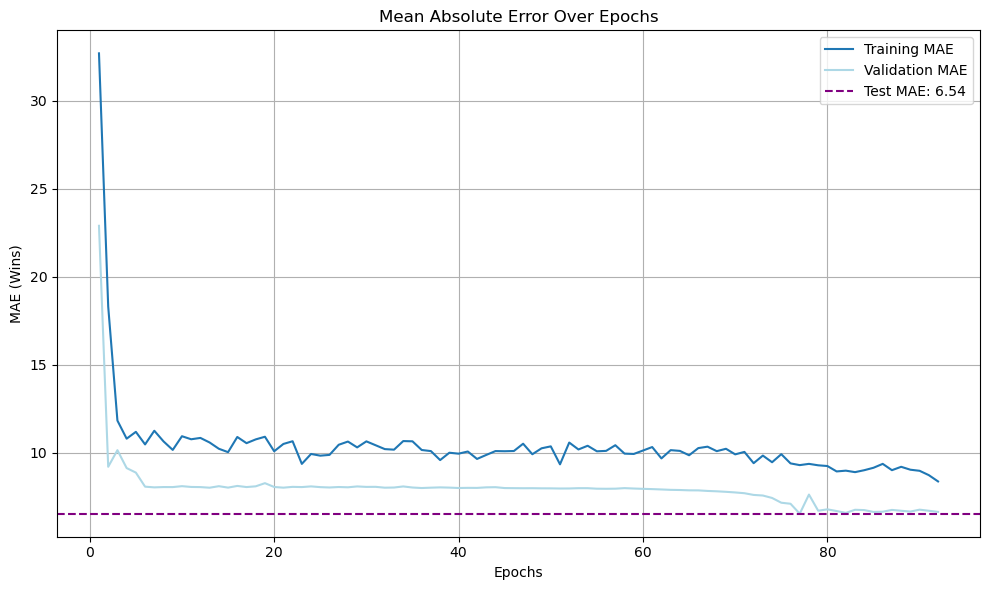

In [518]:
import matplotlib.pyplot as plt

# Extract MAE from history
train_mae = history.history['mae']
val_mae = history.history['val_mae']
epochs = range(1, len(train_mae) + 1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_mae, label='Training MAE')
plt.plot(epochs, val_mae, label='Validation MAE', color='lightblue')

test_mae = 6.54
plt.axhline(y=test_mae, color='purple', linestyle='--', label=f'Test MAE: {test_mae:.2f}')

plt.title('Mean Absolute Error Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE (Wins)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
